# BMM via Gaussian Processes

## Author: Alexandra Semposki

### Date last edited: 15 August 2024

In this notebook, we produce the results in Section IV B of our paper on applying BMM to the equation of state (EOS) of asymmetric nuclear matter. Here, we attempt to use `scikit-learn` to develop a GP with correlated data input to perform BMM, using an altered version of the `GaussianProcessRegressor` class from `sklearn` that is able to incorporate this correlated data. We start with an RBF kernel and a Constant Kernel to optimize the marginal variance, $\bar{c}^{2}$. This kernel choice can be changed to reflect other priors the user may wish to implement. 

---

#### Table of contents

1. [Setting up the training data](#setup)
2. [Calculation of the mixed model in $P(n)$](#calc_p_n)
3. [Calculation of the speed of sound squared, $c_{s}^{2}(n)$](#calc_cs2)

---

In [1]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

---

## Setting up the training data <a id="setup"></a>

First, we load in the data sets from $\chi$EFT and pQCD from which we will select training points, and choose the N3LO and N2LO results, respectively. Notice that we are using the results from pure $\chi$EFT, up to $2n_{0}$ only, since GPs do not need to have training points across the entire space to be used.

In [2]:
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
print(data_xeft['density'].shape)
#data_xeft_2 = np.load('quick_cheft_data.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

(600,)


Now we do some Python gymnastics to obtain the training points we'd like to use.

In [3]:
# call training function to obtain desired data (for both data sets) (change now to test)
data_xeft_2 = {
    'density': data_xeft['density'][::2],
    'mean': data_xeft['mean'][::2],
    'std_dev': data_xeft['std_dev'][::2],
    'cov': data_xeft['cov'][::2,::2]
    
}

# data_xeft_3 = {
#     'density': data_xeft['density'][50::2],
#     'mean': data_xeft['mean'][50::2],
#     'std_dev': data_xeft['std_dev'][50::2],
#     'cov': data_xeft['cov'][50::2,50::2]
# }

cutoff = 40
chiral_tr_data, pqcd_tr_data, training_data_new = gp_data(data_xeft_2, data_pqcd, cutoff, all_orders=False)
#training_data_3 = gp_data(data_xeft_3, data_pqcd, cutoff, all_orders=False)

# save this to a file for later use in multi-plotter (uncomment to save)
# np.savez('../data/NSM_data/correlated_training_data_20n0_NSM.npz', density=training_data['dens'], \
#          dens_log=np.log(training_data['dens']), mean=training_data['mean'], \
#          std=training_data['std'], cov=training_data['cov'])

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

(8,) (8,) (8,) (8, 8)
(8,) (8,) (8,) (8, 8)
(4,) (4,) (4,) (4, 4)
Cov shape: (12, 12)


The cell below shows the results that we obtained for Table II in the paper (Sec. IV B). 

In [4]:
from scipy.linalg import block_diag

# make training data out of the first set
chiral_tr_final = {
    'dens': chiral_tr_data['dens'][::2],
    'mean': chiral_tr_data['mean'][::2],
    'std': chiral_tr_data['std'][::2],
    'cov': chiral_tr_data['cov'][::2,::2]
}

pqcd_tr_final = {
    'dens': pqcd_tr_data['dens'],
    'mean': pqcd_tr_data['mean'],
    'std': pqcd_tr_data['std'],
    'cov': pqcd_tr_data['cov']
}

# training_data = {
#     'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_final['dens'])),
#     'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_final['mean'])),
#     'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_final['std'])),
#     'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_final['cov'])
# }

training_data = {
    'dens': chiral_tr_final['dens'], 
    'mean': chiral_tr_final['mean'],
    'std': chiral_tr_final['std'],
    'cov': chiral_tr_final['cov']
}

# training_data = {
#     'dens': np.concatenate((chiral_tr_final['dens'][1:], pqcd_tr_final['dens'])),
#     'mean': np.concatenate((chiral_tr_final['mean'][1:], pqcd_tr_final['mean'])),
#     'std': np.concatenate((chiral_tr_final['std'][1:], pqcd_tr_final['std'])),
#     'cov': block_diag(chiral_tr_final['cov'][1:,1:], pqcd_tr_final['cov'])
# }

# training_data_2 = {
#     'dens': np.concatenate((chiral_tr_data['dens'][::2], pqcd_tr_data['dens'])),
#     'mean': np.concatenate((chiral_tr_data['mean'][::2], pqcd_tr_data['mean'])),
#     'std': np.concatenate((chiral_tr_data['std'][::2], pqcd_tr_data['std'])),
#     'cov': block_diag(chiral_tr_data['cov'][::2,::2], pqcd_tr_data['cov'])   # needed
# }

# training_data_2 = {
#     'dens': np.concatenate((chiral_tr_data['dens'][:-1], pqcd_tr_data['dens'])),
#     'mean': np.concatenate((chiral_tr_data['mean'][:-1], pqcd_tr_data['mean'])),
#     'std': np.concatenate((chiral_tr_data['std'][:-1], pqcd_tr_data['std'])),
#     'cov': block_diag(chiral_tr_data['cov'][:-1,:-1], pqcd_tr_data['cov']) 
# }

training_data_2 = {
    'dens': chiral_tr_data['dens'][:-1],
    'mean': chiral_tr_data['mean'][:-1],
    'std': chiral_tr_data['std'][:-1],
    'cov': chiral_tr_data['cov'][:-1,:-1]
}

training_data_mix12 = {
    'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_data['dens'][:-1])),
    'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_data['mean'][:-1])),
    'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_data['std'][:-1])),
    'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_data['cov'][:-1,:-1])
}

training_data_mix21 = {
    'dens': np.concatenate((chiral_tr_data['dens'][:-1], pqcd_tr_final['dens'])),
    'mean': np.concatenate((chiral_tr_data['mean'][:-1], pqcd_tr_final['mean'])),
    'std': np.concatenate((chiral_tr_data['std'][:-1], pqcd_tr_final['std'])),
    'cov': block_diag(chiral_tr_data['cov'][:-1,:-1], pqcd_tr_final['cov'])
}

# print training data for Table II results
print('Density: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

print('\nDensity: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

# print('Shape of covariance: ', training_data_2['cov'].shape)
# print('Covariance:', training_data_2['cov'])

Density: 
 [0.12843072 0.18652755 0.24462437 0.3027212 ]

Mean: 
 [0.06581348 0.12163018 0.18751852 0.24768873]

Std dev: 
 [0.00863102 0.0193103  0.03546397 0.0587477 ]

Density: 
 [0.12843072 0.15747913 0.18652755 0.21557596 0.24462437 0.27367279
 0.3027212 ]

Mean: 
 [0.06581348 0.09170063 0.12163018 0.15424626 0.18751852 0.21936115
 0.24768873]

Std dev: 
 [0.00863102 0.01336194 0.0193103  0.02662078 0.03546397 0.04606986
 0.0587477 ]


Now we get ready to plot the selected training data and the total means and uncertainties from the two theories. $\chi$EFT and pQCD are always displayed in red and blue, respectively.

In [5]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="r",
    ls="none",
    marker="o",
    markerfacecolor="r",
    markeredgecolor="r",
    markersize=3
)

In [6]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean']
p_stdv_xeft = data_xeft['std_dev']
p_cov_xeft = data_xeft['cov']

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

# save this for plotting later (uncomment to save)
#np.savez('../data/NSM_data/pressure_pqcd_cut_20_NSM.npz', dens=n_pqcd, mean=p_mean_pqcd, std=p_stdv_pqcd)

Now we'll plot the current data sets with the cutoffs implemented for each, and the training points that we will be using to train the GP.

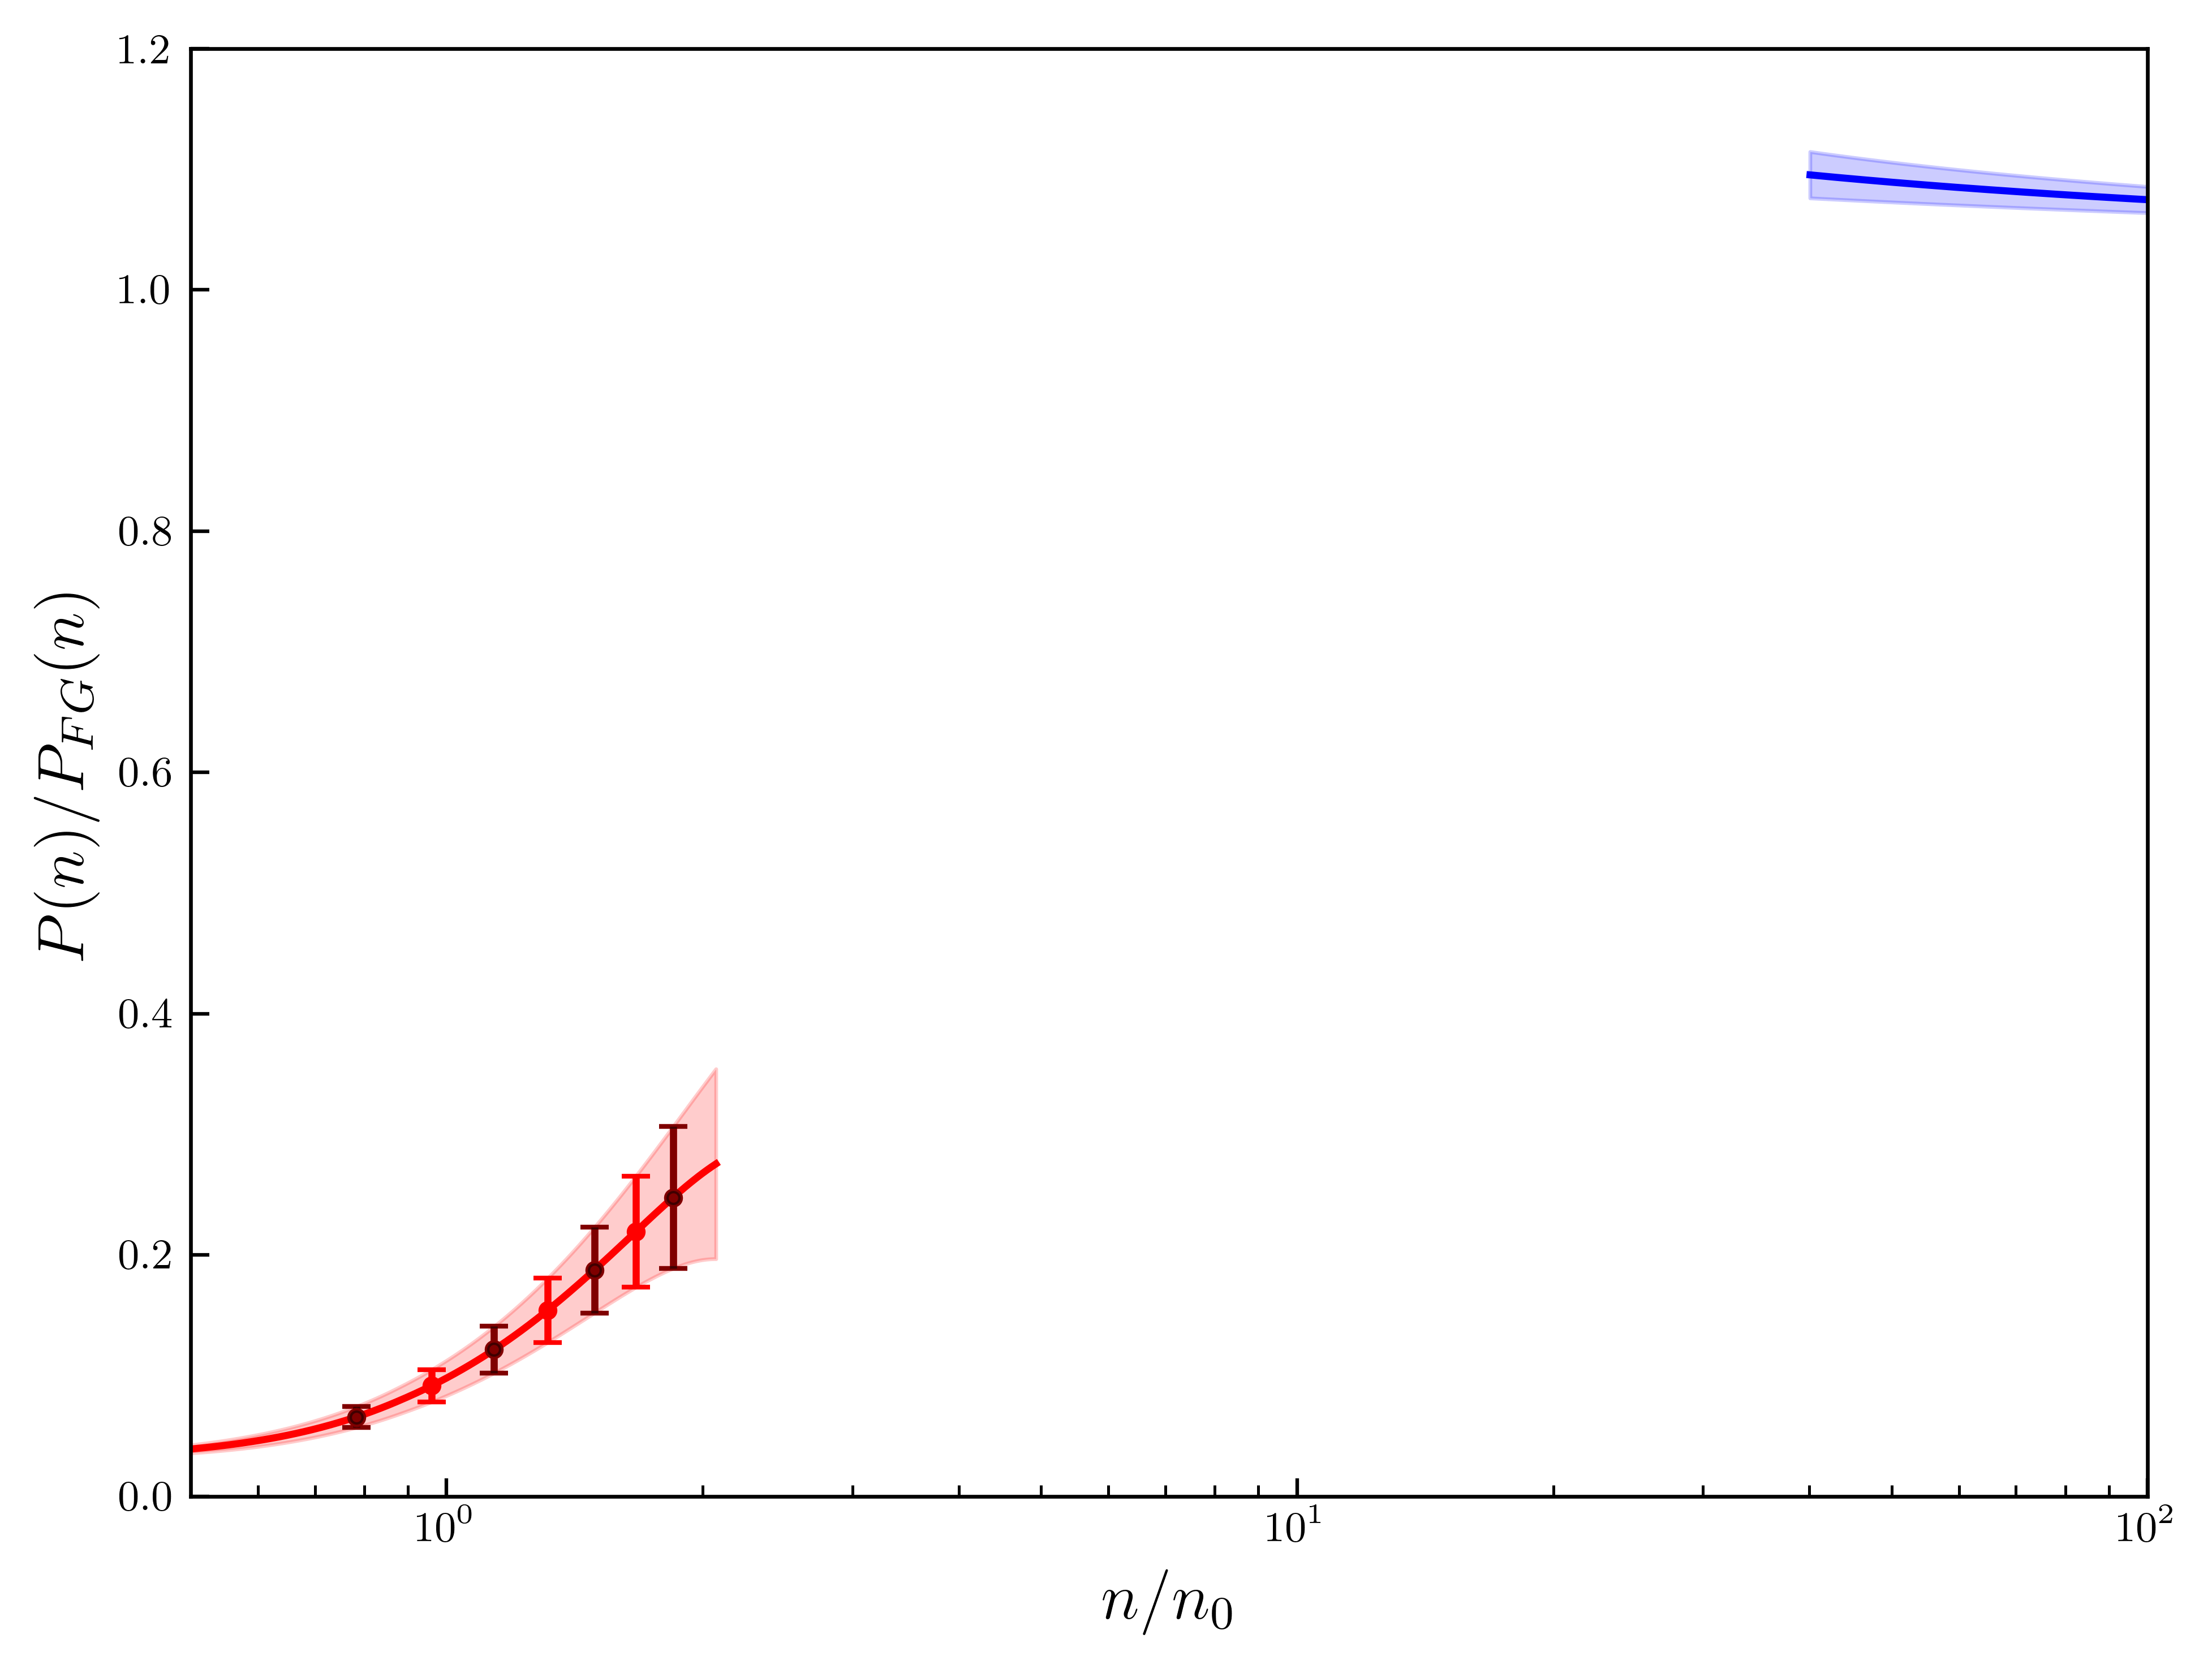

In [7]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(0.5, 100.0)
ax.set_ylim(0, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], \
            **errorbar_kwargs, alpha=0.5)

# result of idea 2
# ax.plot(n_xeft_2/n0, p_mean_xeft_2, color='green', label=r'ChEFT (N3LO)')
# ax.fill_between(n_xeft_2/n0, p_mean_xeft_2-p_stdv_xeft_2, p_mean_xeft_2+p_stdv_xeft_2, \
#                 alpha=0.2, color=color_xeft_2)
# ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
#             **errorbar_kwargs_2)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
#plt.legend()
plt.show()

In [84]:
# # SVD of the two matrices for 4 and 7 points
# from scipy.linalg import svd

# u_4, s_4, v_4 = svd(training_data['cov'][:-4,:-4])
# u_7, s_7, v_7 = svd(training_data_2['cov'][:-4,:-4])

# print('Eigenvalues of 4 points: \n', s_4)
# print('\nEigenvalues of 7 points: \n', s_7)

# plt.plot(s_4/s_4[0], 'b.', label=r'4 $\chi$EFT points', markersize=14)
# plt.plot(s_7/s_7[0], 'r.', label=r'{} $\chi$EFT points'.format(len(training_data_2['dens'][:-4])), markersize=14)
# plt.yscale('log')
# plt.title('Chiral EFT data')
# plt.legend(fontsize=14, loc='upper right')
# plt.show()

## Calculation of $P(n)$ using a GP <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, the RBF * constant kernel. Then we will feed this to the `GaussianProcessRegressor2dNoise` function that ties to `sklearn`, and fit to the training data we selected.

We also need to compare the results of the work with the comparison of what happens when I use the same covariance matrix, and fix the lengthscale to reflect the two kernels I see when I work on the RBF kernel with two different covariance matrices.

In [85]:
# choose kernel
if cutoff == 40:
#     kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
#     RBF(length_scale=1.1, length_scale_bounds=[0.6,1.2])
    kernel = C(constant_value=1.0, constant_value_bounds='fixed') \
    * RBF(length_scale=1.1, length_scale_bounds='fixed')
elif cutoff == 20:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.8, length_scale_bounds=[0.3, 1.0])
#     kernel = C(constant_value=1.0) \
#     * RBF(length_scale=0.9)

# kernel_2 = C(constant_value=1.0) * RBF(length_scale=0.9)

# kernel_3 = C(constant_value=1.0) * RBF(length_scale=1.0, length_scale_bounds='fixed')

# kernel_4 = C(constant_value=1.0, constant_value_bounds=[0.95, 1.05]) * \
# RBF(length_scale=1.0, length_scale_bounds='fixed')

# kernel_5 = C(constant_value=1.0) * RBF(length_scale=1.5, length_scale_bounds='fixed')

# kernel_6 = C(constant_value=1.0) * RBF(length_scale=0.75, length_scale_bounds='fixed')

#constant_value_bounds=[0.3,2.25]) * \ 
#length_scale_bounds=[0.7, 1.2])  # 40n0 => [0.7,1.2] # 20n0 => 1.1?

X_train = np.log(training_data['dens']).reshape(-1,1)  # training in the log scale
y_train = training_data['mean'].reshape(-1,1)

X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train_2 = training_data_2['mean'].reshape(-1,1)

# create a small diagonal chicken nugget for the matrix (not needed without a prior?)
nugget = 1e-12*np.diag(np.ones(len(training_data['cov'])))
nugget_2 = 1e-08*np.diag(np.ones(len(training_data_2['cov'])))

# set up the class for the GP
# gp = GaussianProcessRegressor2dNoise(
#     kernel=kernel,
#     alpha=training_data_2['cov'] + nugget,  # here is where we input the full covariance matrix from the data
#     n_restarts_optimizer=10000,
# )

# gp.fit(X_train, y_train, priors=True, cutoff=cutoff, prior_choice='uniform')  
# fit to the data we selected from chiral EFT & pQCD

# # set up the class for the GP (second kernel) 
# gp2 = GaussianProcessRegressor2dNoise(
#     kernel=kernel_2,
#     alpha=training_data_2['cov'],
#     n_restarts_optimizer=10,
# )

# gp2.fit(X_train, y_train, priors=False)  # fit to the data we selected from chiral EFT & pQCD

# gp3 = GaussianProcessRegressor2dNoise(
#     kernel=kernel_3,
#     alpha=training_data_2['cov'],
# )

# gp3.fit(X_train, y_train, priors=False)  # fit to the data we selected from chiral EFT & pQCD

# gp4 = GaussianProcessRegressor2dNoise(
#     kernel=kernel_4,
#     alpha=training_data_2['cov'],
# )

# gp4.fit(X_train, y_train, priors=False)  # fit to the data we selected from chiral EFT & pQCD

# gp5 = GaussianProcessRegressor2dNoise(
#     kernel=kernel_5,
#     alpha=training_data_2['cov'],
# )

# gp5.fit(X_train, y_train, priors=False)  # fit to the data we selected from chiral EFT & pQCD

# gp6 =  GaussianProcessRegressor2dNoise(
#     kernel=kernel_6,
#     alpha=training_data_2['cov'],
# )

# gp6.fit(X_train, y_train, priors=False)

In [86]:
# running plot of multiple hyperprior choices
gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data['cov'], #+ nugget,  # here is where we input the full covariance matrix from the data
#    n_restarts_optimizer=1000,
)

gp.fit(X_train, y_train, priors=False, cutoff=cutoff, prior_choice='truncnorm_15')  

# running plot of multiple hyperprior choices
gp1 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'] + nugget_2,  # here is where we input the full covariance matrix from the data
#    n_restarts_optimizer=1000
)

gp1.fit(X_train_2, y_train_2, priors=False, cutoff=cutoff, prior_choice='truncnorm_15')  


# gp1 = GaussianProcessRegressor2dNoise(
#     kernel=kernel,
#     alpha=training_data_2['cov'] + nugget,  # here is where we input the full covariance matrix from the data
#     n_restarts_optimizer=10000,
# )

# gp1.fit(X_train, y_train, priors=True, cutoff=cutoff, prior_choice='uniform')  

# gp2 = GaussianProcessRegressor2dNoise(
#     kernel=kernel,
#     alpha=training_data_2['cov'] + nugget,  # here is where we input the full covariance matrix from the data
#     n_restarts_optimizer=10000,
# )

# gp2.fit(X_train, y_train, priors=True, cutoff=cutoff, prior_choice='skewnorm')  

# gp3 = GaussianProcessRegressor2dNoise(  # -2
#     kernel=kernel,
#     alpha=training_data_2['cov'] + nugget,  # here is where we input the full covariance matrix from the data
#     n_restarts_optimizer=10000,
# )

# gp3.fit(X_train, y_train, priors=True, cutoff=cutoff, prior_choice='skewnorm_constrained')  

GaussianProcessRegressor2dNoise(alpha=array([[7.45044453e-05, 1.13999261e-04, 1.59815255e-04, 2.10703960e-04,
        2.65531716e-04, 3.23566619e-04, 3.84534049e-04],
       [1.13999261e-04, 1.78551436e-04, 2.55582589e-04, 3.43447191e-04,
        4.40418219e-04, 5.45256948e-04, 6.57361796e-04],
       [1.59815255e-04, 2.55582589e-04, 3.72897544e-04, 5.09906255e-04,
        6.64447771e-04, 8.34770036e-04,...
       [2.65531716e-04, 4.40418219e-04, 6.64447771e-04, 9.37437275e-04,
        1.25770351e-03, 1.62356800e-03, 2.03414616e-03],
       [3.23566619e-04, 5.45256948e-04, 8.34770035e-04, 1.19423230e-03,
        1.62356800e-03, 2.12244235e-03, 2.69105322e-03],
       [3.84534049e-04, 6.57361796e-04, 1.01989478e-03, 1.47786462e-03,
        2.03414616e-03, 2.69105322e-03, 3.45130215e-03]]),
                                kernel=1**2 * RBF(length_scale=1.1))

We can print out the kernel hyperparameters ($\bar{c}$ and $\ell$) below, and see what we get using this kernel.

In [87]:
print(gp.kernel_)
print(gp1.kernel_)
# print(gp2.kernel_)
# print(gp3.kernel_) # -2

1**2 * RBF(length_scale=1.1)
1**2 * RBF(length_scale=1.1)


In [88]:
# data peak from log likelihood
log_likelihood = []
log_likelihood_2 = []
ell = np.linspace(0.5, 2.0, 200)
# for ls in ell:
#     kernel = C(constant_value=0.6) * RBF(length_scale=ls, length_scale_bounds='fixed')
#     gp = GaussianProcessRegressor2dNoise(
#     kernel=kernel,
#     alpha=training_data['cov']  # here is where we input the full covariance matrix from the data
#     )
#     gp.fit(X_train, y_train, priors=False)
#     log_likelihood.append(gp.log_marginal_likelihood())
    
# for ls in ell:
#     kernel = C(constant_value=0.6) * RBF(length_scale=ls, length_scale_bounds='fixed')
#     gp2 = GaussianProcessRegressor2dNoise(
#     kernel=kernel,
#     alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
#     )
#     gp2.fit(X_train_2, y_train_2, priors=False)
#     log_likelihood_2.append(gp2.log_marginal_likelihood())
    
# plt.plot(ell, log_likelihood)
# plt.plot(ell, log_likelihood_2)
# plt.xlabel(r'$\ell$')
# plt.text(1.4, 2.0, r'Log marginal likelihood comparison ($20n_{0}$)')
# plt.show()

In [89]:
# idx = np.where([i == max(log_likelihood) for i in log_likelihood])[0][0]
# print(ell[idx])
# idx2 = np.where([i == max(log_likelihood_2) for i in log_likelihood_2])[0][0]
# print(ell[idx2])

In [90]:
#conversion for speed of sound
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

In [91]:
# use the testing density array now for predicting at new locations (also in log space)
X = np.log(density_test).reshape(-1,1)

y_pred_0, y_stdv_0 = gp.predict(X, return_std=True)
_, y_cov_0 = gp.predict(X, return_cov=True)

y_pred_1, y_stdv_1 = gp1.predict(X, return_std=True)
_, y_cov_1 = gp1.predict(X, return_cov=True)

# y_pred_2, y_stdv_2 = gp2.predict(X, return_std=True)

# y_pred_3, y_stdv_3 = gp3.predict(X, return_std=True) # -2

#_, y_cov_3 = gp3.predict(X, return_cov=True)

# save for plotting later (uncomment to save)
#np.savez('../data/NSM_data/gp_pressure_20_NSM.npz', dens=density_test, mean=y_pred_1, std=y_stdv_1)

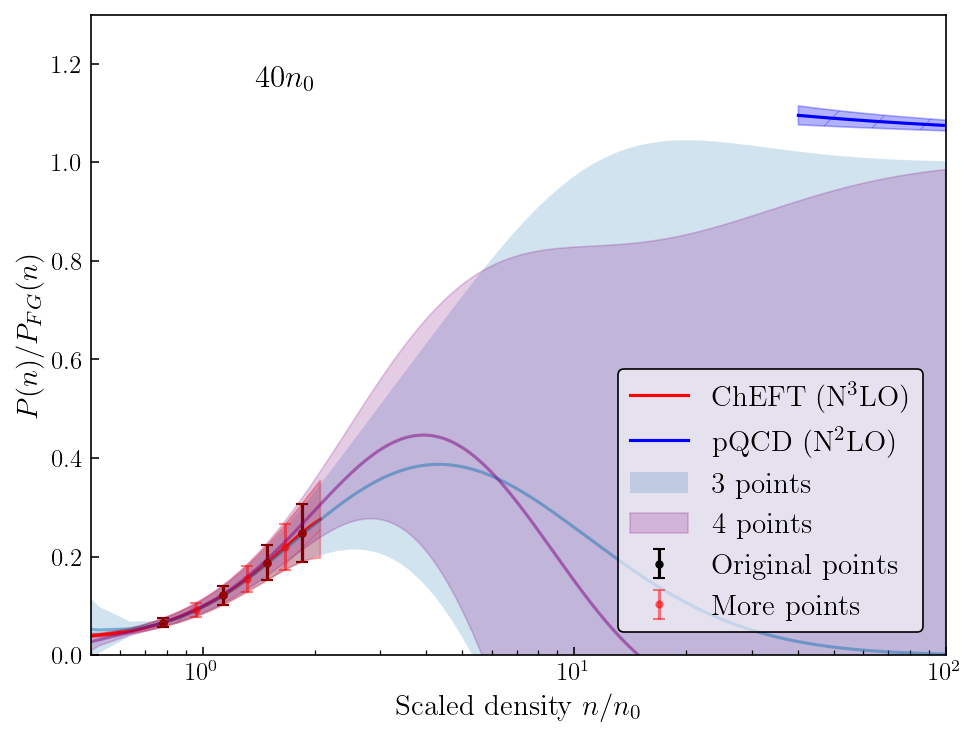

In [93]:
fig, ax = plt.subplots(dpi=150)
ax.set_xlim(min(density_test/n0), 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N$^3$LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.3, \
                color=color_xeft, hatch='/')
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], color='k', \
            **errorbar_kwargs, label=r'Original points')
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], color='r', \
            **errorbar_kwargs_2, label=r'More points', alpha=0.5)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N$^2$LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.3, color=color_pqcd, \
               hatch='/')

# GP kernel choice results and uncertainty bands
ax.plot(density_test/n0, y_pred_0, alpha=0.5)
ax.plot(density_test/n0, y_pred_1, alpha=0.5, color='purple')
ax.fill_between(density_test/n0, y_pred_0-y_stdv_0, y_pred_0+y_stdv_0, \
                label=r'3 points', \
                alpha=0.2)
ax.fill_between(density_test/n0, y_pred_1-y_stdv_1, y_pred_1+y_stdv_1, \
                label=r'4 points', \
                color='purple', alpha=0.2)

# ax.plot(density_test/n0, y_pred_2, c='green', zorder=5, alpha=0.5)
# ax.fill_between(density_test/n0, y_pred_2-y_stdv_2, y_pred_2+y_stdv_2, label=r'9 points', \
#                 color="green", alpha=0.2, zorder=4)

# ax.plot(density_test/n0, y_pred_3, c='purple', zorder=7, alpha=0.5)
# ax.fill_between(density_test/n0, y_pred_3-y_stdv_3, y_pred_3+y_stdv_3, color="purple", \
#                 label=r'Skewed norm ($a=-2$)', alpha=0.2, zorder=6)

plt.text(
    2.0,1.2, '${}n_0$'.format(cutoff), ha='right', va='top',
    multialignment='center', zorder=10, fontsize=15)
plt.xlim(0.5, 100.0)
plt.ylim(0.0, 1.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
plt.legend(fontsize=14, loc='lower right')
#plt.savefig('Plots/hyperprior_settings_analysis/more_points_inside_40n0.png')
plt.show()

In [94]:
# now check at 0.5*n0
width_blue_hn0 = (y_pred_0[2]+y_stdv_0[2]) - (y_pred_0[2]-y_stdv_0[2])
width_orange_hn0 = (y_pred_1[2]+y_stdv_1[2]) - (y_pred_1[2]-y_stdv_1[2])
ind_chi_hn0 = np.where([data_xeft['density'][i] <= 0.08 for i in range(len(data_xeft['density']))])[0][-1]
width_chi_hn0 = (data_xeft['mean'][ind_chi_hn0]+data_xeft['std_dev'][ind_chi_hn0]) - \
(data_xeft['mean'][ind_chi_hn0]-data_xeft['std_dev'][ind_chi_hn0])

print('Relative error difference, blue to chiral at 1/2n0: \n', \
      (np.abs((width_blue_hn0 - width_chi_hn0))/(width_chi_hn0))*100)
print('Relative error difference, purple to chiral at 1/2n0: \n', \
     (np.abs((width_orange_hn0 - width_chi_hn0))/(width_chi_hn0))*100)
print('Absolute error difference at 1/2n0:\n', np.abs((width_orange_hn0 - width_blue_hn0)))
print('Relative percent difference at 1/2n0:\n', (np.abs((width_orange_hn0 - width_blue_hn0))\
                                               /(width_orange_hn0 + width_blue_hn0)*100))

# now let's check the width differences in the above error bands at n0
width_blue_n0 = (y_pred_0[6]+y_stdv_0[6]) - (y_pred_0[6]-y_stdv_0[6])
width_orange_n0 = (y_pred_1[6]+y_stdv_1[6]) - (y_pred_1[6]-y_stdv_1[6])
ind_chi_n0 = np.where([data_xeft['density'][i] <= 0.164 for i in range(len(data_xeft['density']))])[0][-1]
width_chi_n0 = (data_xeft['mean'][ind_chi_n0]+data_xeft['std_dev'][ind_chi_n0]) - \
(data_xeft['mean'][ind_chi_n0]-data_xeft['std_dev'][ind_chi_n0])

print('\nRelative error difference, blue to chiral at n0: \n', \
      (np.abs((width_blue_n0 - width_chi_n0))/(width_chi_n0))*100)
print('Relative error difference, purple to chiral at n0: \n', \
     (np.abs((width_orange_n0 - width_chi_n0))/(width_chi_n0))*100)
print('Absolute error difference at n0:\n', np.abs((width_orange_n0 - width_blue_n0)))
print('Relative percent difference at n0:\n', (np.abs((width_orange_n0 - width_blue_n0))\
                                               /(width_orange_n0 + width_blue_n0)*100))

# now error bands at 2*n0
width_blue = (y_pred_0[16]+y_stdv_0[16]) - (y_pred_0[16]-y_stdv_0[16])
width_orange = (y_pred_1[16]+y_stdv_1[16]) - (y_pred_1[16]-y_stdv_1[16])
ind_chi = np.where([data_xeft['density'][i] <= 0.34 for i in range(len(data_xeft['density']))])[0][-1]
width_chi = (data_xeft['mean'][ind_chi]+data_xeft['std_dev'][ind_chi]) - \
(data_xeft['mean'][ind_chi]-data_xeft['std_dev'][ind_chi])

print('\nRelative error difference, blue to chiral at 2n0: \n', \
      (np.abs((width_blue - width_chi))/(width_chi))*100)
print('Relative error difference, purple to chiral at 2n0: \n', \
     (np.abs((width_orange - width_chi))/(width_chi))*100)
print('Absolute error difference at 2n0:\n', np.abs((width_orange - width_blue)))
print('Relative percent difference at 2n0:\n', (np.abs((width_orange - width_blue))/\
                                                (width_orange + width_blue)*100))

Relative error difference, blue to chiral at 1/2n0: 
 1397.4442823970967
Relative error difference, purple to chiral at 1/2n0: 
 291.15683073412504
Absolute error difference at 1/2n0:
 0.06907443577492385
Relative percent difference at 1/2n0:
 58.57708353400221

Relative error difference, blue to chiral at n0: 
 5.68302109142893
Relative error difference, purple to chiral at n0: 
 8.276991150738992
Absolute error difference at n0:
 0.0007544203685459216
Relative percent difference at n0:
 1.394307799399895

Relative error difference, blue to chiral at 2n0: 
 7.415495585788272
Relative error difference, purple to chiral at 2n0: 
 14.72196030129607
Absolute error difference at 2n0:
 0.011504910929691636
Relative percent difference at 2n0:
 4.107927698857891


In [95]:
# correlation coefficients with pQCD
# check out the covariance matrix
print(y_cov_0.shape)
print(y_cov_1.shape)
index_2n0 = np.where([density_test[i] >= 0.34 for i in range(len(density_test))])[0][0]
print([index_2n0])
index_40n0 = np.where([density_test[i] >= 6.56 for i in range(len(density_test))])[0][0]

# covariances
y_var0_2n0 = y_cov_0[index_2n0, index_2n0]
y_var0_40n0 = y_cov_0[index_40n0, index_40n0]
y_cross0_2n0_40n0 = y_cov_0[index_2n0, index_40n0]

# covariances between 5n0 and 40n0 here
y_var1_2n0 = y_cov_1[index_2n0, index_2n0]
y_var1_40n0 = y_cov_1[index_40n0, index_40n0]
y_cross1_2n0_40n0 = y_cov_1[index_2n0, index_40n0]

# correlation coefficients
corr_coeff = y_cross0_2n0_40n0 / (np.sqrt(y_var0_2n0) * np.sqrt(y_var0_40n0))
corr_coeff_2 = y_cross1_2n0_40n0 / (np.sqrt(y_var1_2n0) * np.sqrt(y_var1_40n0))
print('Correlation coefficient, blue curve: ', corr_coeff)
print('Correlation coefficient, purple curve: ', corr_coeff_2)

(899, 899)
(899, 899)
[16]
Correlation coefficient, blue curve:  0.044523768758765486
Correlation coefficient, purple curve:  0.08904134658152821


In [96]:
# adding the SVD together for the traces
print('SVD trace, blue curve: \n', np.sum(s_4))
print('SVD trace, purple curve: \n', np.sum(s_7))

SVD trace, blue curve: 
 0.005156367647790149
SVD trace, purple curve: 
 0.008166007329270811


__Questions__: 

- Is 5 points the proper number of training data to include from chiral, given the results here?
- Is the SVD a valid way of choosing the number of points to feed the GP in the chiral EFT data set?

(899, 500)


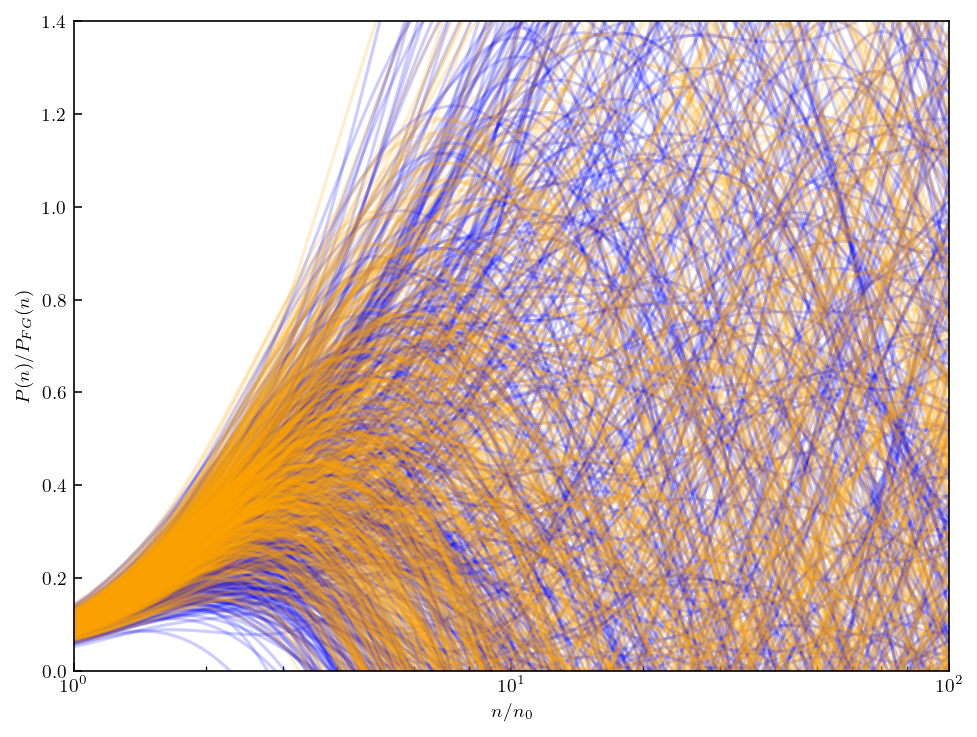

(899, 500)
Widths of (scaled) curves around saturation:
4 points: 0.3715110452792678
7 points: 0.37383393242808227
Chiral EFT: 0.36987807431182773
Widths of (scaled) curves around twice saturation:
4 points: 0.9776956737936491
7 points: 0.8223074848477783
Chiral EFT: 1.0774928240912232


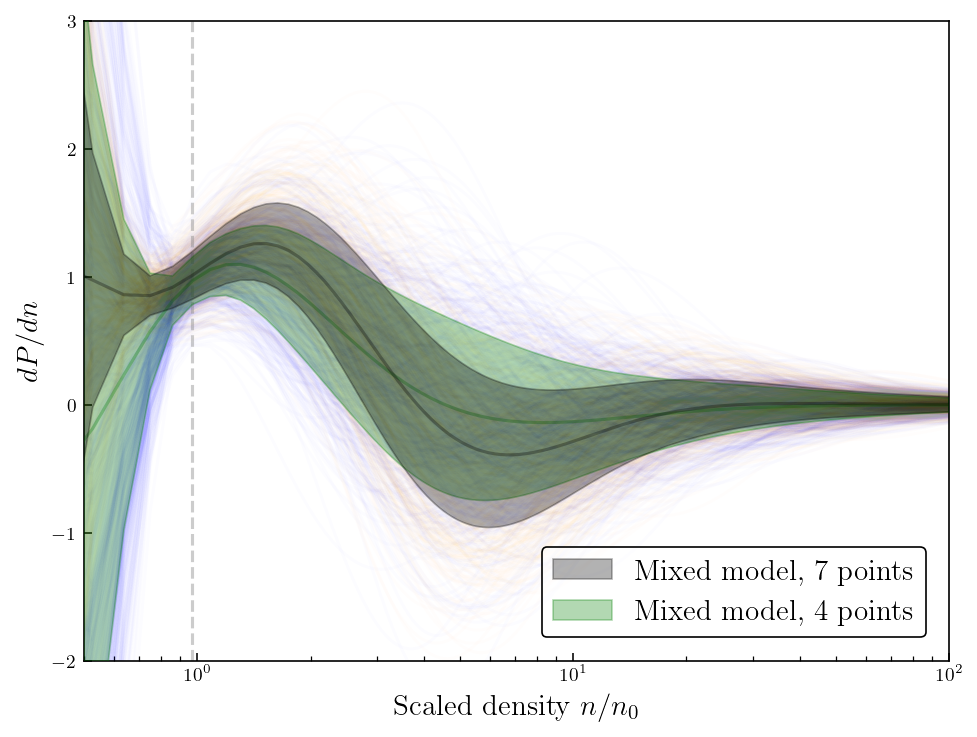

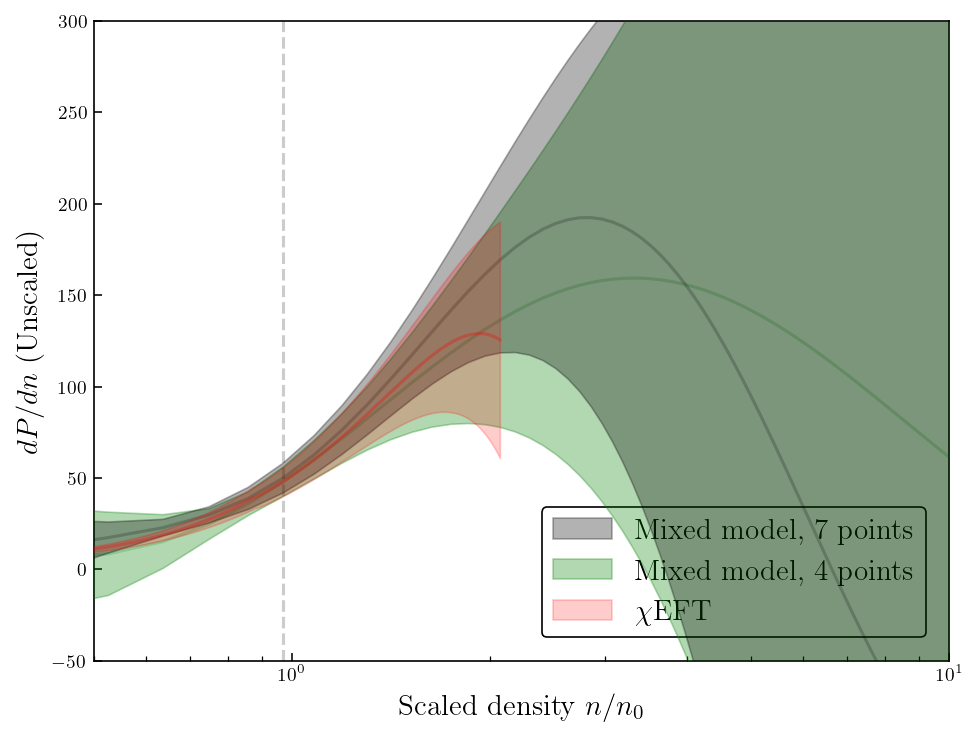

In [104]:
# investigate the derivative tendancies above for 4 vs. 7 points
deriv_chiral = np.load('../data/NSM_data/dP_dn_NSM_scaled.npz')
deriv_chiral_unscaled = np.load('../data/NSM_data/dP_dn_NSM.npz')

# obtain simple gradients for the two above first (lol these are hilariously uninformative as we guessed)
deriv_mixed4_mean = np.gradient(y_pred_0, density_test, edge_order=2)
deriv_mixed4_lower = np.gradient((y_pred_0 - y_stdv_0), density_test, edge_order=2)
deriv_mixed4_upper = np.gradient((y_pred_0 + y_stdv_0), density_test, edge_order=2)
deriv_mixed7_mean = np.gradient(y_pred_1, density_test, edge_order=2)
deriv_mixed7_lower = np.gradient((y_pred_1 - y_stdv_1), density_test, edge_order=2)
deriv_mixed7_upper = np.gradient((y_pred_1 + y_stdv_1), density_test, edge_order=2)

# plt.plot(density_test/n0, deriv_mixed4_mean, color='blue')
# plt.fill_between(density_test/n0, deriv_mixed4_lower, deriv_mixed4_upper, alpha=0.3, color='blue')
# plt.plot(density_test/n0, deriv_mixed7_mean, color='orange')
# plt.fill_between(density_test/n0, deriv_mixed7_lower, deriv_mixed7_upper, alpha=0.3, color='orange')
# plt.xscale('log')
# plt.show()

# moving on to drawing samples for a better look
samples = 500
samples_data4 = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=samples)
samples_data7 = gp1.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=samples)

# undo the scaling from P_FG to see how this looks
print(samples_data4.shape)
samples4_unscaled = np.asarray([samples_data4[:,i]*pqcd_convert_arr \
                         for i in range(len(np.asarray(samples_data4).T))]).T
samples7_unscaled = np.asarray([samples_data7[:,i]*pqcd_convert_arr \
                         for i in range(len(np.asarray(samples_data7).T))]).T

# plot the samples to test the validity of the call
plt.plot(density_test/n0, samples_data4, color='blue', alpha=0.2)
plt.plot(density_test/n0, samples_data7, color='orange', alpha=0.2)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

# take derivatives of these samples (not the all-inclusive gptools variety though...
# but can be done anyway numerically, from what I can tell?)
# 4 
dPdn_samples4 = np.gradient(samples_data4, density_test, axis=0, edge_order=2)
dPdn_mean4 = np.nanmean(dPdn_samples4, axis=1)
dPdn_std4 = np.nanstd(dPdn_samples4, axis=1)

# 7
dPdn_samples7 = np.gradient(samples_data7, density_test, axis=0, edge_order=2)
dPdn_mean7 = np.nanmean(dPdn_samples7, axis=1)
dPdn_std7 = np.nanstd(dPdn_samples7, axis=1)

# 4 unscaled
print(samples4_unscaled.shape)
dPdn_samples4_unscaled = np.gradient(samples4_unscaled, density_test, axis=0, edge_order=2)
dPdn_mean4_unscaled = np.nanmean(dPdn_samples4_unscaled, axis=1)
dPdn_std4_unscaled = np.nanstd(dPdn_samples4_unscaled, axis=1)

# 7 unscaled
dPdn_samples7_unscaled = np.gradient(samples7_unscaled, density_test, axis=0, edge_order=2)
dPdn_mean7_unscaled = np.nanmean(dPdn_samples7_unscaled, axis=1)
dPdn_std7_unscaled = np.nanstd(dPdn_samples7_unscaled, axis=1)

# find approx. saturation density in the array
ind_sat = np.where([density_test[i] <= 0.164 for i in range(len(density_test))])[0][-1]
ind_chi = np.where([deriv_chiral['density'][i] <= density_test[ind_sat] \
                    for i in range(len(deriv_chiral['density']))])[0][-1]

# find approx. saturation density in the array
ind_sat_2n0 = np.where([density_test[i] <= 0.328 for i in range(len(density_test))])[0][-1]
ind_chi_2n0 = np.where([deriv_chiral['density'][i] <= density_test[ind_sat_2n0] \
                    for i in range(len(deriv_chiral['density']))])[0][-1]

width4_2n0 = (dPdn_mean4[ind_sat_2n0]+dPdn_std4[ind_sat_2n0]) - \
(dPdn_mean4[ind_sat_2n0] - dPdn_std4[ind_sat_2n0])
width7_2n0 = (dPdn_mean7[ind_sat_2n0]+dPdn_std7[ind_sat_2n0]) - \
(dPdn_mean7[ind_sat_2n0] - dPdn_std7[ind_sat_2n0])
widthchi_2n0 = (deriv_chiral['mean'][ind_chi_2n0] + \
            deriv_chiral['std'][ind_chi_2n0]) - (deriv_chiral['mean'][ind_chi_2n0] \
                                             -  deriv_chiral['std'][ind_chi_2n0])

# find the numbers at this line!!! unscaled and scaled versions
unscaled_width4 = (dPdn_mean4_unscaled+dPdn_std4_unscaled) - (dPdn_mean4_unscaled - dPdn_std4_unscaled)
unscaled_width7 = (dPdn_mean7_unscaled+dPdn_std7_unscaled) - (dPdn_mean7_unscaled - dPdn_std7_unscaled)
unscaled_widthchi = (deriv_chiral_unscaled['mean'][ind_chi] +  \
                     deriv_chiral_unscaled['std'][ind_chi]) - (deriv_chiral_unscaled['mean'][ind_chi] -  \
                                                      deriv_chiral_unscaled['std'][ind_chi])

width4 = (dPdn_mean4[ind_sat]+dPdn_std4[ind_sat]) - (dPdn_mean4[ind_sat] - dPdn_std4[ind_sat])
width7 = (dPdn_mean7[ind_sat]+dPdn_std7[ind_sat]) - (dPdn_mean7[ind_sat] - dPdn_std7[ind_sat])
widthchi = (deriv_chiral['mean'][ind_chi] + \
            deriv_chiral['std'][ind_chi]) - (deriv_chiral['mean'][ind_chi] \
                                             -  deriv_chiral['std'][ind_chi])

print('Widths of (scaled) curves around saturation:')
print('4 points: {}'.format(width4))
print('7 points: {}'.format(width7))
print('Chiral EFT: {}'.format(widthchi))

print('Widths of (scaled) curves around twice saturation:')
print('4 points: {}'.format(width4_2n0))
print('7 points: {}'.format(width7_2n0))
print('Chiral EFT: {}'.format(widthchi_2n0))
                                             
plt.plot(density_test/n0, dPdn_samples4, color='blue', alpha=0.01)
plt.plot(density_test/n0, dPdn_samples7, color='orange', alpha=0.01)
plt.fill_between(density_test/n0, dPdn_mean7-dPdn_std7, dPdn_mean7+dPdn_std7, color='black', \
                 alpha=0.3, zorder=8, label=r'Mixed model, 7 points')
plt.plot(density_test/n0, dPdn_mean7, color='black', alpha=0.3, zorder=9)
plt.fill_between(density_test/n0, dPdn_mean4-dPdn_std4, dPdn_mean4+dPdn_std4, color='green', \
                 alpha=0.3, zorder=6, label=r'Mixed model, 4 points')
plt.plot(density_test/n0, dPdn_mean4, color='green', alpha=0.3, zorder=7)
# plt.fill_between(deriv_chiral['density']/n0, deriv_chiral['mean']-deriv_chiral['std'], \
#                  deriv_chiral['mean']+deriv_chiral['std'], color='red', alpha=0.3, zorder=10, \
#                  label=r'$\chi$EFT')
# plt.plot(deriv_chiral['density']/n0, deriv_chiral['mean'], color='red', alpha=0.3, zorder=11)
plt.axvline(x=density_test[ind_sat]/n0, linestyle='dashed', color='grey', alpha=0.4)
plt.xlim(0.5, 100.0)
plt.xscale('log')
plt.ylabel(r'$dP/dn$', fontsize=14)
plt.ylim(-2.0, 3.0)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.legend(fontsize=14, loc='lower right')
plt.show()

# unscaled plot
# plt.plot(density_test/n0, dPdn_samples4_unscaled, color='blue', alpha=0.01)
# plt.plot(density_test/n0, dPdn_samples7_unscaled, color='orange', alpha=0.01)
plt.fill_between(density_test/n0, dPdn_mean7_unscaled-dPdn_std7_unscaled, \
                 dPdn_mean7_unscaled+dPdn_std7_unscaled, color='black', \
                 alpha=0.3, zorder=8, label=r'Mixed model, 7 points')
plt.plot(density_test/n0, dPdn_mean7_unscaled, color='black', alpha=0.2, zorder=9)
plt.fill_between(density_test/n0, dPdn_mean4_unscaled-dPdn_std4_unscaled, \
                 dPdn_mean4_unscaled+dPdn_std4_unscaled, color='green', \
                 alpha=0.3, zorder=6, label=r'Mixed model, 4 points')
plt.plot(density_test/n0, dPdn_mean4_unscaled, color='green', alpha=0.2, zorder=7)
plt.fill_between(deriv_chiral_unscaled['density']/n0, \
                 deriv_chiral_unscaled['mean']-deriv_chiral_unscaled['std'], \
                 deriv_chiral_unscaled['mean']+deriv_chiral_unscaled['std'], \
                 color='red', alpha=0.2, zorder=10, label=r'$\chi$EFT')
plt.plot(deriv_chiral_unscaled['density']/n0, deriv_chiral_unscaled['mean'], \
         color='red', alpha=0.3, zorder=11)
plt.axvline(x=density_test[ind_sat]/n0, linestyle='dashed', alpha=0.4, color='grey')
plt.xlim(0.5, 10.0)
plt.xscale('log')
plt.ylabel(r'$dP/dn$ (Unscaled)', fontsize=14)
plt.ylim(-50.0, 300.0)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.legend(fontsize=14, loc='lower right')
plt.show()

In [100]:
# compare the size of the error bars for both theories below at some select point (last point)
band_chiral = p_stdv_xeft[-1]
band_gp = y_stdv_1[16]           # 2n0
band_pqcd = p_stdv_pqcd[0]

if cutoff == 20:
    index_pqcd20 = np.where([density_test[i] <= 3.28 for i in range(len(density_test))])[0][-1]
    band_gp_pqcd = y_stdv_1[index_pqcd20]
elif cutoff == 40:
    index_pqcd40 = np.where([density_test[i] <= 6.56 for i in range(len(density_test))])[0][-1]
    band_gp_pqcd = y_stdv_1[index_pqcd40]
print('here', band_gp_pqcd)
print('here 2', band_pqcd)
print('Density at chosen point:', density_test[16], 'fm^-3')

# compare for reduction in uncertainty
var_chiral = band_chiral**2.0
print('Chiral variance:', var_chiral)
var_gp = 0.775**2.0
print('Untrained prior GP variance (cbar^2):', var_gp)
var_mm = band_gp**2.0
print('Mixed model variance (post-training):', var_mm)

# combine
combined = var_chiral * var_gp / (var_chiral + var_gp)
print('Calculated combined variance:', combined)

# print out the differences
print('Difference between bands: ', ((band_chiral - band_gp)/(band_chiral))*100)
print('Difference between GP and pQCD: ', (np.abs(band_pqcd - band_gp_pqcd)/band_pqcd)*100)

here 0.9893465130618375
here 2 0.019212404416336728
Density at chosen point: 0.3409899888765294 fm^-3
Chiral variance: 0.006198576243747575
Untrained prior GP variance (cbar^2): 0.6006250000000001
Mixed model variance (post-training): 0.004507817909477518
Calculated combined variance: 0.006135259080483441
Difference between bands:  14.721960301296082
Difference between GP and pQCD:  5049.519506369408


---

### Overlay of results for $20n_0$ and $40n_0$ $P(n)$

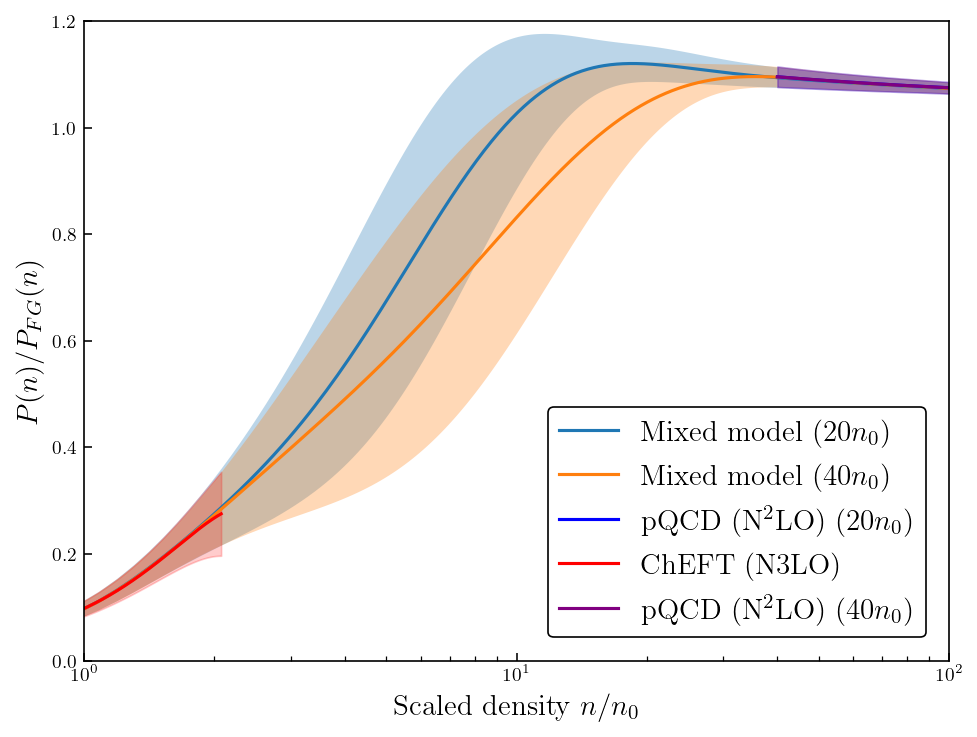

In [19]:
pqcd_20 = np.load('../data/NSM_data/pressure_pqcd_cut_20_NSM.npz')
pqcd_40 = np.load('../data/NSM_data/pressure_pqcd_cut_40_NSM.npz')
pressure_20 = np.load('../data/NSM_data/gp_pressure_20_NSM.npz')
pressure_40 = np.load('../data/NSM_data/gp_pressure_40_NSM.npz')
data_20 = np.load('../data/NSM_data/correlated_training_data_20n0_NSM.npz')
data_40 = np.load('../data/NSM_data/correlated_training_data_40n0_NSM.npz')

plt.plot(pressure_20['dens']/n0, pressure_20['mean'], label=r'Mixed model ($20n_0$)')
plt.plot(pressure_40['dens']/n0, pressure_40['mean'], label=r'Mixed model ($40n_0$)')
plt.fill_between(pressure_20['dens']/n0, pressure_20['mean']-pressure_20['std'], \
                 pressure_20['mean']+pressure_20['std'], alpha=0.3)
plt.fill_between(pressure_40['dens']/n0, pressure_40['mean']-pressure_40['std'], \
                 pressure_40['mean']+pressure_40['std'], alpha=0.3)

plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N$^2$LO) ($20n_0$)')
plt.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
#plt.errorbar(x=data_40['density']/n0, y=data_40['mean'], yerr=data_40['std'], **errorbar_kwargs)

plt.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
plt.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, \
                color=color_xeft)
# plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
#             **errorbar_kwargs)

plt.plot(pqcd_40['dens']/n0, pqcd_40['mean'], color='purple', label=r'pQCD (N$^2$LO) ($40n_0$)')
plt.fill_between(pqcd_40['dens']/n0, pqcd_40['mean']-pqcd_40['std'], pqcd_40['mean']+pqcd_40['std'], \
                 alpha=0.2, color='purple')

plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.2)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
plt.xscale('log')
plt.legend(fontsize=14)
#plt.savefig('overlay_pressures.png')
plt.show()

---

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="calc_cs2"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density, as we did as well in the pointwise mixing notebook. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{n}^{n_{i}} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(n_{i})}{n_{i}} \right],
$$

where $n_{i}$ is 16.4 fm$^{-3}$, as we will be integrating downwards from pQCD to $\chi$EFT in this approach.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu(n) = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu(n)} \frac{\partial P(n)}{\partial n}.
$$

We have a utility function that runs both the integration and the speed of sound calculation, so we will call that and implement the speed of sound. However, we first need to sample from the GP, since this is the way to best propagate the uncertainties from the pressure to the speed of sound without drastically overestimating them.

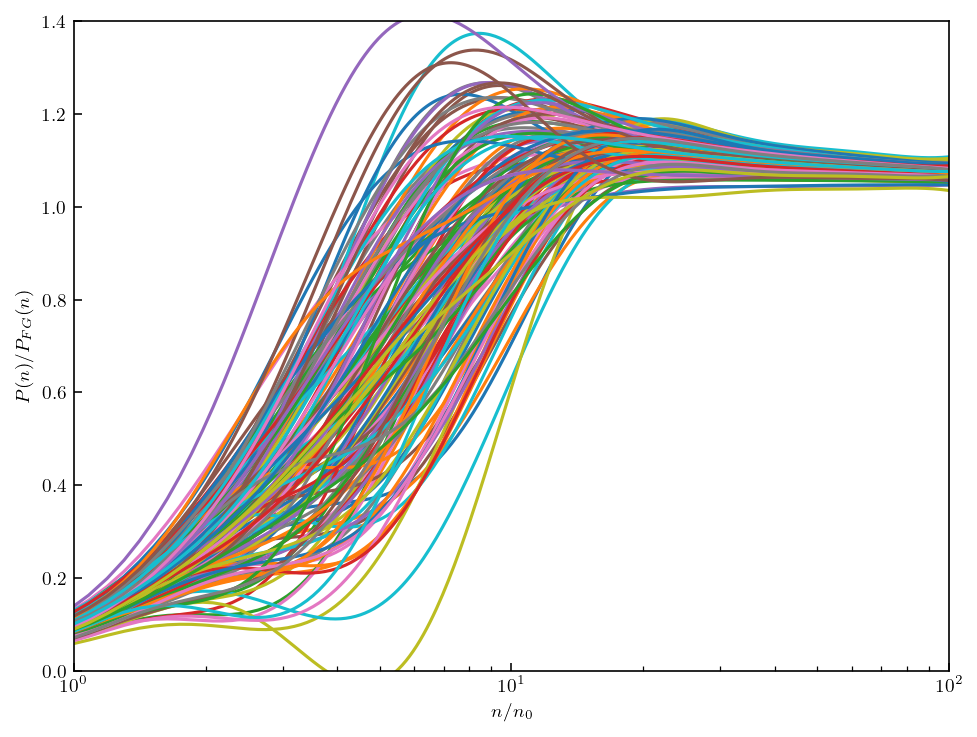

In [15]:
# sample from the pressure GP curve first (we'll need a LOT...eventually)
samples = 150
samples_data = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=samples)

# plot the samples to test the validity of the call
plt.plot(density_test/n0, samples_data)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

In [16]:
# use the testing density array now for predicting at new locations (also in log space)
y_pred_2, y_stdv_2 = gp2.predict(X, return_std=True)
_, y_cov_2 = gp2.predict(X, return_cov=True)

# use the testing density array now for predicting at new locations (also in log space)
y_pred_3, y_stdv_3 = gp3.predict(X, return_std=True)
_, y_cov_3 = gp3.predict(X, return_cov=True)

# use the testing density array now for predicting at new locations (also in log space)
y_pred_4, y_stdv_4 = gp4.predict(X, return_std=True)
_, y_cov_4 = gp4.predict(X, return_cov=True)

# use the testing density array now for predicting at new locations (also in log space)
y_pred_5, y_stdv_5 = gp5.predict(X, return_std=True)
_, y_cov_5 = gp5.predict(X, return_cov=True)

# use the testing density array now for predicting at new locations (also in log space)
y_pred_6, y_stdv_6 = gp6.predict(X, return_std=True)
_, y_cov_6 = gp6.predict(X, return_cov=True)

In [17]:
# let's pull a couple of samples for some work with the kernels and hyperpriors
sample_store = {
    '20': [0,11,10],
    '40': [0,1,14]
}
samples_tests = 20
samples_data_tests = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=samples_tests, \
                                 random_state=41)  # 2 good curves that look reasonable (got it)

# store in a single array
sample_true_20 = np.column_stack([samples_data_tests[:,j] for j in sample_store['20']])
sample_true_40 = np.column_stack([samples_data_tests[:,j] for j in sample_store['40']])
sample_true = np.column_stack([sample_true_20, sample_true_40])

NameError: name 'pres_dict' is not defined

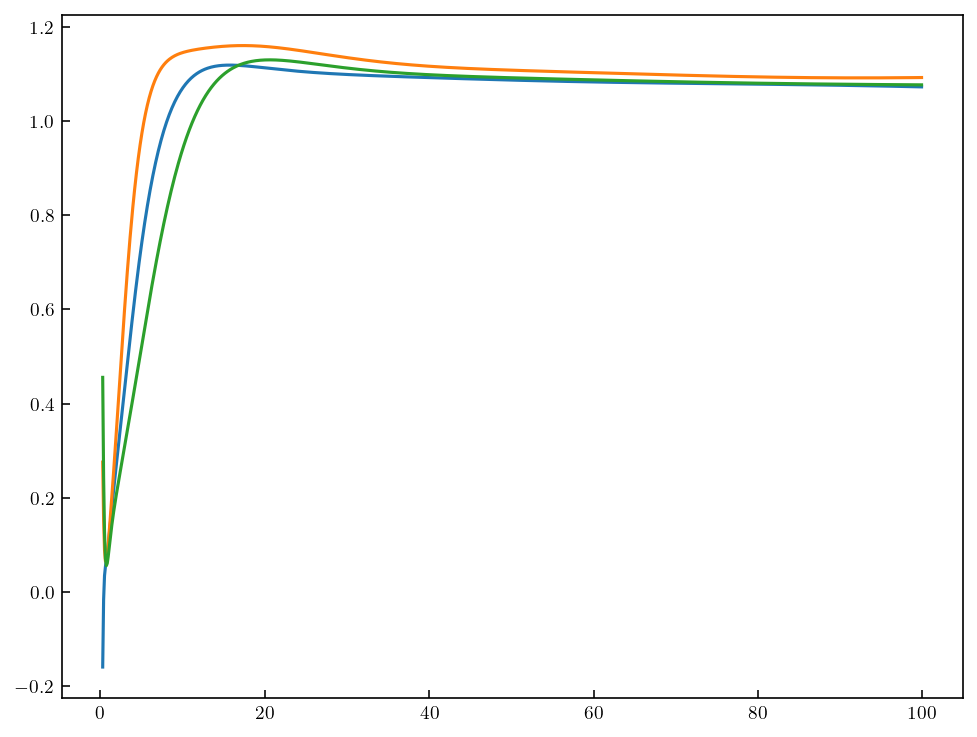

In [18]:
# plot with the 68% interval underneath for guidance
[plt.plot(density_test/n0, samples_data_tests[:,j], zorder=20) \
 for j in sample_store['40']]
plt.fill_between(density_test/n0, (pres_dict['mean']-pres_dict['std_dev'])/\
                 gp_cs2_convert_arr, \
                 (pres_dict['mean']+pres_dict['std_dev'])/gp_cs2_convert_arr, \
                 color='black', alpha=0.2, zorder=10, label=r'68\% CI')
plt.fill_between(density_test/n0, (pres_dict['mean']-1.96*pres_dict['std_dev'])/\
                 gp_cs2_convert_arr, \
                 (pres_dict['mean']+1.96*pres_dict['std_dev'])/gp_cs2_convert_arr, \
                 color='grey', alpha=0.2, zorder=5, label=r'95\% CI')
plt.ylabel(r'Scaled pressure $P(n)/P_{FG}(n)$', fontsize=14)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.legend()
#plt.savefig('Plots/analysis_priors/original_draws_20.png')
plt.show()

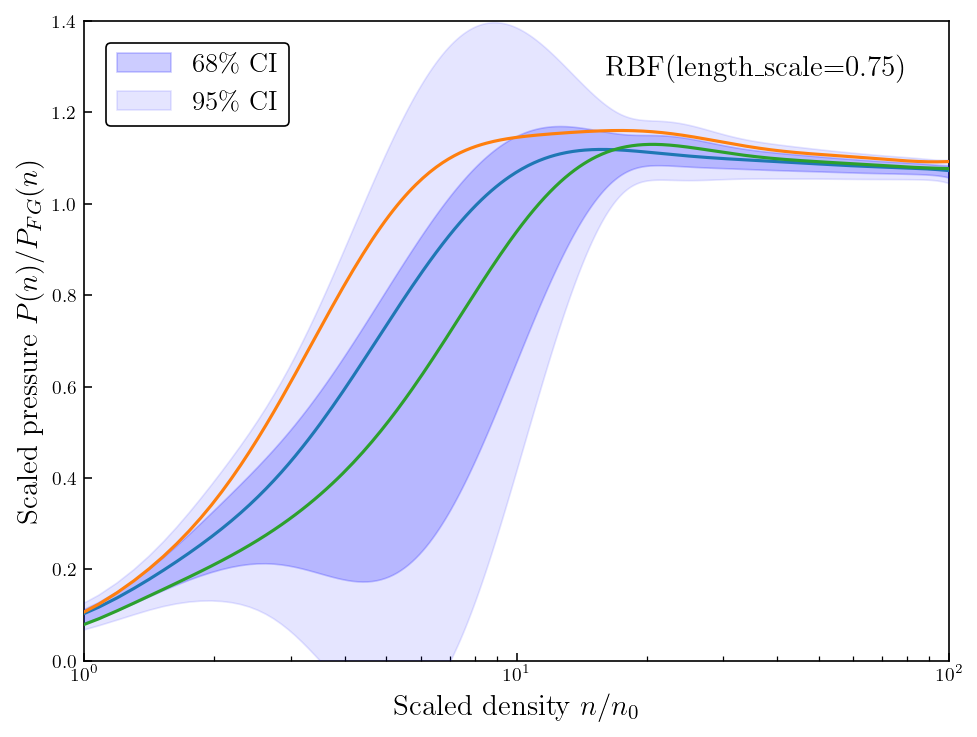

In [19]:
# plot with the 68% interval underneath for guidance
[plt.plot(density_test/n0, samples_data_tests[:,j], zorder=20) \
 for j in sample_store['40']]

# gp_ls = gp2.kernel_.k2
# plt.fill_between(density_test/n0, (y_pred_2-y_stdv_2), (y_pred_2+y_stdv_2), \
#                  color='purple', alpha=0.2, zorder=10, label=r'68\% no hyperprior')
# plt.fill_between(density_test/n0, (y_pred_2-1.96*y_stdv_2), (y_pred_2+1.96*y_stdv_2), \
#                  color='purple', alpha=0.1, zorder=10, label=r'95\% no hyperprior')

# gp_ls = gp3.kernel_.k2
# plt.fill_between(density_test/n0, (y_pred_3-y_stdv_3), (y_pred_3+y_stdv_3), \
#                  color='red', alpha=0.2, zorder=5, label=r'68\% CI')
# plt.fill_between(density_test/n0, (y_pred_3-1.96*y_stdv_3), (y_pred_3+1.96*y_stdv_3), \
#                  color='red', alpha=0.1, zorder=5, label=r'95\% CI')

# gp_ls = gp4.kernel_.k2
# plt.fill_between(density_test/n0, (y_pred_4-y_stdv_4), (y_pred_4+y_stdv_4), \
#                  color='orange', alpha=0.3, zorder=6, \
#                  label=r'68\% max ls=1, $\bar{c}^{2}=1$')
# plt.fill_between(density_test/n0, (y_pred_4-1.96*y_stdv_4), (y_pred_4+1.96*y_stdv_4), \
#                  color='orange', alpha=0.2, zorder=6, \
#                  label=r'95\% max ls=1, $\bar{c}^{2}=1$')

# gp_ls = gp.kernel_.k2
# plt.fill_between(density_test/n0, (pres_dict['mean']-pres_dict['std_dev'])/gp_cs2_convert_arr, \
#                  (pres_dict['mean']+pres_dict['std_dev'])/gp_cs2_convert_arr, \
#                  color='black', alpha=0.2, zorder=10, \
#                  label=r'68\% truncated normal hyperprior')
# plt.fill_between(density_test/n0, (pres_dict['mean']-1.96*pres_dict['std_dev'])/\
#                  gp_cs2_convert_arr, \
#                  (pres_dict['mean']+1.96*pres_dict['std_dev'])/gp_cs2_convert_arr, \
#                  color='black', alpha=0.1, zorder=10, label=r'95\% truncated normal hyperprior')

# gp_ls = gp5.kernel_.k2
# plt.fill_between(density_test/n0, (y_pred_5-y_stdv_5), (y_pred_5+y_stdv_5), \
#                  color='green', alpha=0.3, zorder=5, label=r'68\% CI')
# plt.fill_between(density_test/n0, (y_pred_5-1.96*y_stdv_5), (y_pred_5+1.96*y_stdv_5), \
#                  color='green', alpha=0.2, zorder=5, label=r'95\% CI')

gp_ls = gp6.kernel_.k2
plt.fill_between(density_test/n0, (y_pred_6-y_stdv_6), (y_pred_6+y_stdv_6), \
                 color='blue', alpha=0.2, zorder=6, label=r'68\% CI')
plt.fill_between(density_test/n0, (y_pred_6-1.96*y_stdv_6), (y_pred_6+1.96*y_stdv_6), \
                 color='blue', alpha=0.1, zorder=5, label=r'95\% CI')

plt.ylabel(r'Scaled pressure $P(n)/P_{FG}(n)$', fontsize=14)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize= 14)
plt.text(
    80.0,1.33, r'{}'.format(gp_ls), ha='right', va='top',
    multialignment='center', zorder=10, fontsize=14)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=13)
#plt.savefig('Plots/analysis_priors/incremental_plots/fig6_20.png')
plt.show()

In [20]:
from eos_utils import cs2_routine, cs2_plots

# testing the function
gp_dict_full = {
    'dens': density_test,
    'mean': y_pred_1,
    'std_dev': y_stdv_1,
    'samples': samples_data,
    'true': None #sample_true
}

pres_dict, edens_full, cs2_sampled = cs2_routine(gp_dict=gp_dict_full, sat_cut=0, plot=False)

Woo it is over!


In [23]:
# number of samples
samples = len(pres_dict['samples'].T)
print(samples)

# TOV data creation (streamlined)
tov_dict = tov_data(edens_full, pres_dict)

# run the TOV solver over each sample (very janky for now)
mass_data = np.zeros([50,samples])
radius_data = np.zeros([50,samples])
pressure_data = np.zeros([50,samples])

# call the solver once, send all data directly
tov = TOVsolver(eos_filepath='../../../FASTAR/TOV/Alexandra_TOV/eos_tov_true.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data, pressure_data, mass_data = tov.tov_routine(verbose=False)

150
Data not saved.
Woo it worked!
37
Radius:  10.327493576 Maximum mass:  1.6081776680094848 Central pressure:  399.5007639993038
36
Radius:  11.8820616368 Maximum mass:  2.0198061584526896 Central pressure:  342.0973067434033
37
Radius:  8.5451008856 Maximum mass:  1.0475987843077235 Central pressure:  399.5007639993038
37
Radius:  10.327493576 Maximum mass:  1.6081776680094848 Central pressure:  399.5007639993038
36
Radius:  11.9758717784 Maximum mass:  2.087881948192134 Central pressure:  342.0973067434033
43
Radius:  7.1513502104 Maximum mass:  1.1199026137321497 Central pressure:  1013.2704295883759


In [25]:
# now work with the mean and std of pressure, energy density (envelope calculation)
# edens_lower = edens_mean - edens_std
# edens_higher = edens_mean + edens_std
# pres_lower = gp_mean - gp_std
# pres_higher = gp_mean + gp_std
# gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# # concatenate into "samples"
# edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# # save data in dat file backwards
# tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
# edens_final = edens_envelope[tov_index:]
# gp_final = np.asarray([gp_res[tov_index:, i]*\
#                        convert_interp(density_test[tov_index:]) for i in range(3)]).T
# density_final = density_test[tov_index:]

# # run through and append the low density data to these arrays and then save to file
# edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
# pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
# dens_tov = np.concatenate((low_den_file[::-1,2], density_final)).reshape(-1,1)
# cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
# np.savez("../../../FASTAR/TOV/Alexandra_TOV/eos_tov_env_test_40n0.npz", density=dens_tov, \
#          edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

In [78]:
# run the TOV solver over each sample (very janky for now) -> what's up here rn...? weird crossings?
mass_data_env = np.zeros([50,3])
radius_data_env = np.zeros([50,3])
pressure_data_env = np.zeros([50,3])

# call solver once, call routine once
tov_env = TOVsolver(eos_filepath="../../../FASTAR/TOV/Alexandra_TOV/eos_tov_env_test_40n0.npz")
radius_data_env, pressure_data_env, mass_data_env = tov_env.tov_routine(verbose=False)

Woo it worked!
Radius:  9.121818947199998 Maximum mass:  1.2086863910819774 Central pressure:  466.5364423805275
Radius:  9.708161655199998 Maximum mass:  1.441772445579273 Central pressure:  399.5007639993038
Radius:  9.389861327999999 Maximum mass:  1.5643754279388329 Central pressure:  544.8206153354404


One sigma band at max mass: 1.5819235801965492 +/- 0.3975075706316874, aka 1.184416009564862 - 1.9794311508282365


/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_1460/1622989416.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


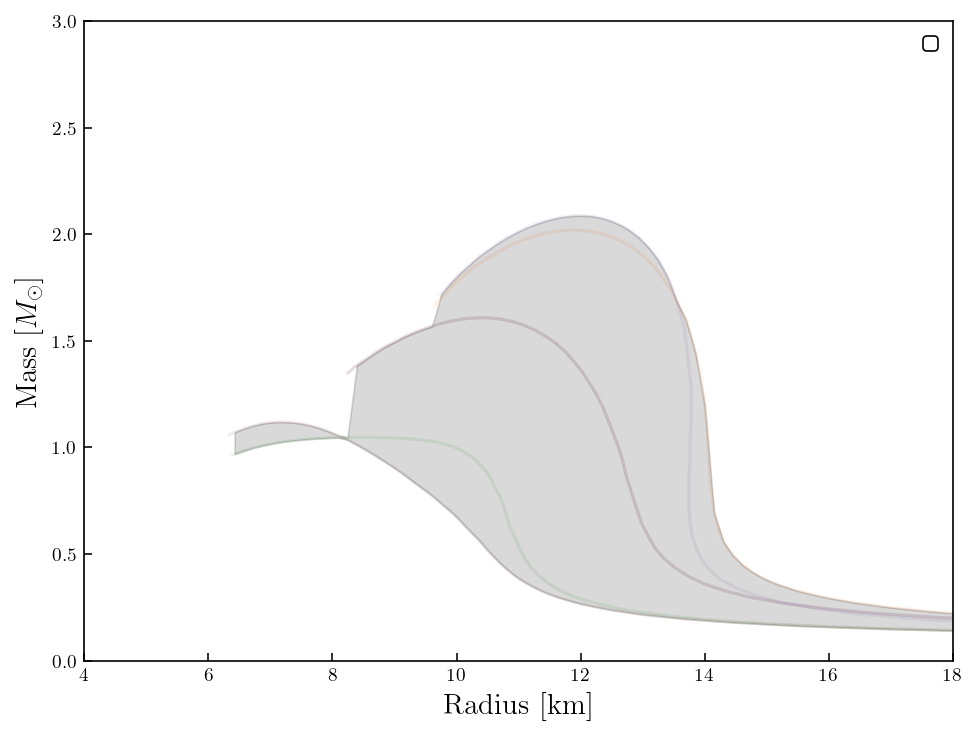

In [109]:
# calculate the mean and std_dev from this plot 
# (use max mass to find the nearest value to the mean, see how that works...)
max_masses = []
for i in range(len(mass_data.T)):
    max_masses.append(max(mass_data[:,i]))

# convert to array and find the mean
max_masses_arr = np.asarray(max_masses)
mean_tov = np.nanmean(max_masses_arr, axis=0)
std_tov = np.nanstd(max_masses_arr, axis=0)
#print(mean_tov) # whoa it actually is equivalent to the GP one...but the bands are crossing for UQ then...
#print(std_tov)  # max mass std dev here, not the full curve
print('One sigma band at max mass: {} +/- {}, aka {} - {}'.format(mean_tov, \
                                                                  std_tov, mean_tov-std_tov, \
                                                                  mean_tov+std_tov))

# calculate the intervals (way #1)
new_rad, mean_mass, std_mass, interpd_mass, median_mass = tov.interval_einfach()

# calculate the intervals (way #2)
new_rad_2, hpd_interval = tov.interval_schwer(fraction=0.90)
#new_rad_3, hpd_interval_2 = tov.interval_schwer(fraction=0.68)

# now interpolate the intervals
reduced_radius_curves, reduced_mass_curves, curves_dict = \
tov.select_curves(new_rad_2, hpd_interval)

# plot the results including the samples and the overall mean, std_dev
plt.plot(radius_data, mass_data, alpha=0.1)
#plt.plot(radius_data_env[:,1], mass_data_env[:,1], linestyle='dashdot', label=r'Mean ($20n_0$)')
#[plt.plot(new_rad, interpd_mass[:,j]) for j in range(samples)]
#plt.fill_between(new_rad, mean_mass-std_mass, mean_mass+std_mass, alpha=0.2)
#plt.plot(new_rad[5:], median_mass[5:], 'r', zorder=22)
plt.fill_between(new_rad_2, hpd_interval[:,0], hpd_interval[:,1], color='black', alpha=0.15, zorder=10)
#plt.fill_between(new_rad_3, hpd_interval_2[:,0], hpd_interval_2[:,1], color='blue', alpha=0.35, zorder=11)
#[plt.plot(reduced_radius_curves[:,i], reduced_mass_curves[:,i]) for i in range(len(reduced_radius_curves.T))]
#plt.fill_between(curves_dict['radius'], curves_dict['lower'], curves_dict['upper'], alpha=0.25)
plt.xlim(4.0, 18.0)
plt.ylim(0.0,3.0)
plt.xlabel(r'Radius [km]', fontsize=14)
plt.ylabel(r'Mass $[M_\odot]$', fontsize=14)
plt.legend()
plt.show()

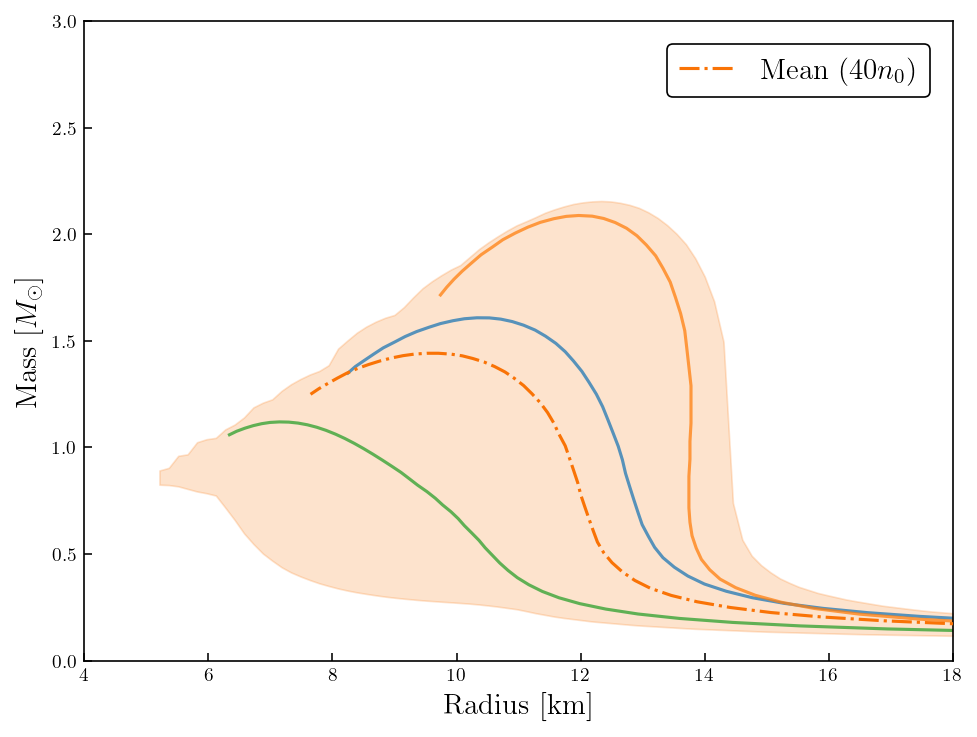

In [171]:
# plot the results including the samples and the overall mean, std_dev
# 20n0
# [plt.plot(radius_data_true[:,i], mass_data_true[:,i], alpha=0.75) for i in range(3)] 
# for i in range(samples)]
# plt.plot(radius_data_env_20[:,1], mass_data_env_20[:,1], 'b', linestyle='dashdot', \
#          label=r'Mean ($20n_0$)', zorder=10)
# plt.fill_between(curves_dict_20['radius'], curves_dict_20['lower'], curves_dict_20['upper'], alpha=0.25)

# 40n0
[plt.plot(radius_data[:,i], mass_data[:,i], alpha=0.75) for i in [3, 4, 5]]
plt.plot(radius_data_env_40[:,1], mass_data_env_40[:,1], linestyle='dashdot', color='#F97306', \
         label=r'Mean ($40n_0$)', zorder=10)
plt.fill_between(curves_dict_40['radius'], curves_dict_40['lower'], curves_dict_40['upper'], \
                 alpha=0.2, color='#F97306')

plt.xlim(4.0, 18.0)
plt.ylim(0.0,3.0)
plt.xlabel(r'Radius [km]', fontsize=14)
plt.ylabel(r'Mass $[M_\odot]$', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('Plots/MR_curves/mr_curve_40_true.PNG')
plt.show()

---

In [74]:
# import the speed of sound data from ChEFT and pQCD
cs2_chiral = np.load('../data/NSM_data/cs2_chiral_NSM.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_NSM.npz')  # --> are we using the correct result here?

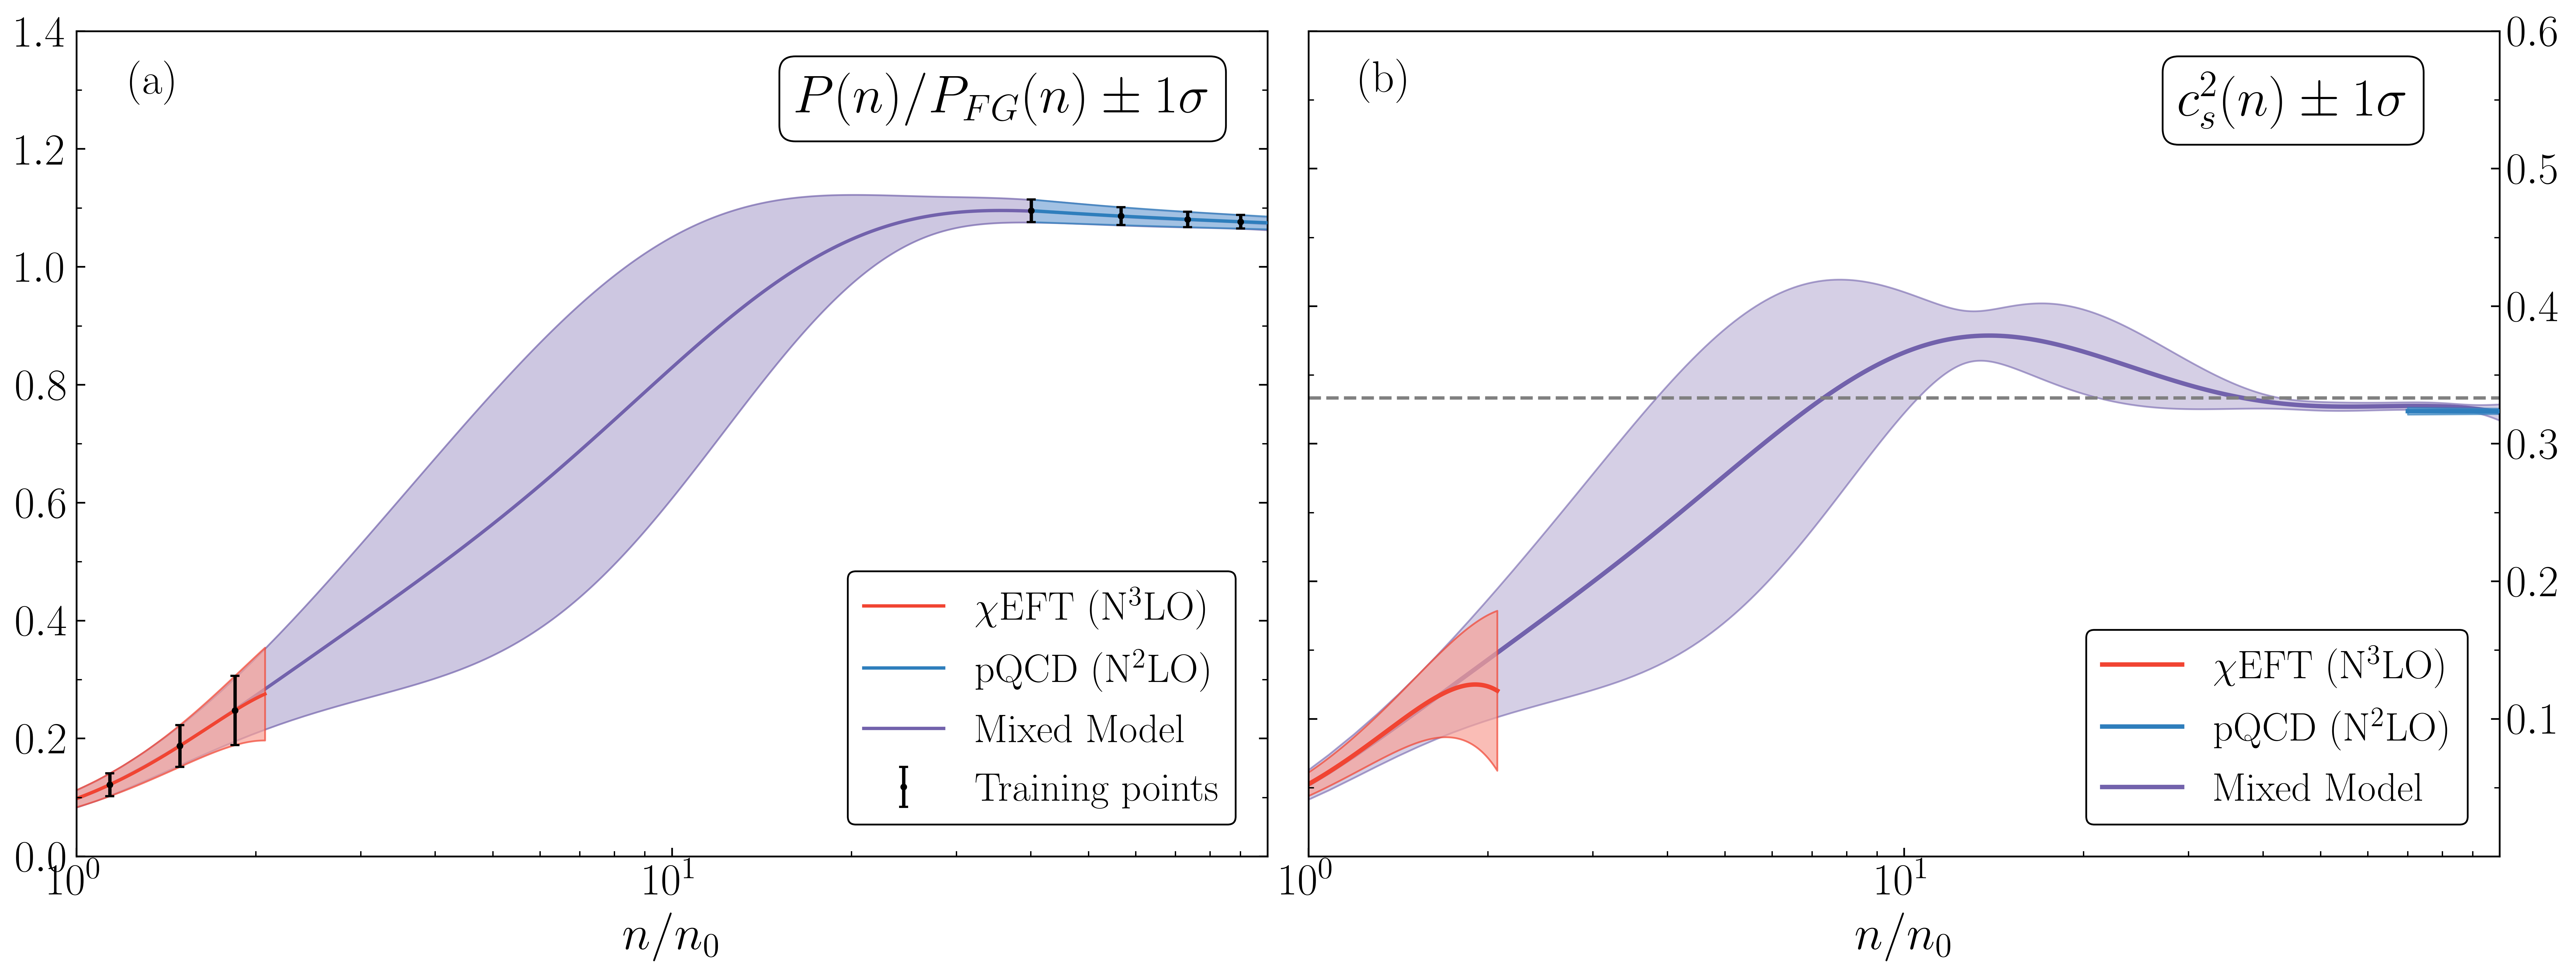

In [75]:
import pandas as pd
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
#fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density_test/n0))
ax[0].set_ylim(0.0,1.4)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.35, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density_test/n0))
ax[1].set_ylim(1e-6,0.6)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 0.58, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use
mean_chiral = data_xeft['mean']
mean_pqcd = data_pqcd['mean'][:,2]
std_dev_chiral = data_xeft['std_dev']
std_dev_pqcd = data_pqcd['std_dev'][:,2]

# pressure data

# model means and uncertainties
ax[0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[0].fill_between(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:] - \
                   1.0*std_dev_pqcd[ind_cut:], mean_pqcd[ind_cut:] + 1.0*std_dev_pqcd[ind_cut:], \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:], zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[0].fill_between(density_test/n0, gp_mean-1.0*gp_std, gp_mean+ \
                   1.0*gp_std,
                       zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(density_test/n0, gp_mean, color=colors[2], zorder=-1, label='Mixed Model')
  
# plot the training points
ax[0].errorbar(training_data["dens"]/n0, training_data["mean"], yerr=training_data["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0].legend(loc='lower right', facecolor='w', fontsize=18)

# speed of sound data 
ax[1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean']+cs2_chiral['std'], \
                 cs2_chiral['mean']-cs2_chiral['std'], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
plt.plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
plt.fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1].fill_between(density_test[sat_cut:]/n0, cs2_sampled['mean']-cs2_sampled['std'], \
                   cs2_sampled['mean']+cs2_sampled['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1].plot(density_test[sat_cut:]/n0, cs2_sampled['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[1].legend(loc='lower right', facecolor='w', fontsize=18)
plt.show()
#fig.savefig('subplot_curvewise_model_40n0.PNG', bbox_inches='tight')

---

## Saving EOS data for the TOV solver

In [70]:
# append the low density data to these arrays when reversed
low_den_file = np.loadtxt("../data/NSM_data/MFT_ns6p.dat", skiprows=1)

# save data in dat file backwards (without cs2 to start)
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_mean[tov_index:]
gp_final = gp_mean[tov_index:]*convert_interp(density_test[tov_index:])
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.concatenate((low_den_file[::-1,0], edens_final))
pres_tov = np.concatenate((low_den_file[::-1,1], gp_final))
dens_tov = np.concatenate((low_den_file[::-1,2], density_final))
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
tov_data = np.column_stack([edens_tov, pres_tov, dens_tov, cs2_tov])
np.savetxt("../../../FASTAR/TOV/Alexandra_TOV/eos_tov_40n0.dat", tov_data)

# try saving to an npz file instead
np.savez('../../../FASTAR/TOV/Alexandra_TOV/eos_zip_test.npz', density=dens_tov, edens=edens_tov, pres=pres_tov, cs2 = cs2_tov)

In [71]:
# try running the solver class object for the npz file format and txt file format
import sys
sys.path.append('../../../TOV_Solver/')
from TOV_class import TOVsolver
tov = TOVsolver(eos_filepath='../../../FASTAR/TOV/Alexandra_TOV/eos_zip_test.npz')

# try running for the single sample and see what happens
max_radius, max_pres_central, max_mass = tov.tov_routine(verbose=False)

Woo it worked!
Radius:  9.453070236289815 Maximum mass:  1.4143352649354075


---

---

## Creating the multi-plot figure in the paper

Below is the code we used to generate the 4 panel figure in our paper. 

In [21]:
# Fig. 8 in our paper

# load in each file of results needed for P(n)
data_xeft = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_cut_20.npz')
data_pqcd_40 = np.load('../data/eos_data/pressure_pqcd_cut_40.npz')
df = pd.read_csv('../data/contour_scaled.csv')
df_frg = pd.read_csv('../data/frg_data_pressure.csv')
training_data_20 = np.load('../data/eos_data/correlated_training_data_20n0.npz')
training_data_40 = np.load('../data/eos_data/correlated_training_data_40n0.npz')
pressure_gp_20 = np.load('../data/eos_data/gp_pressure_20.npz')
pressure_gp_40 = np.load('../data/eos_data/gp_pressure_40.npz')

# load in each file of results need for cs2(n)
cs2_chiral = np.load('../data/eos_data/speedofsoundchiral.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_11.2.npz')
cs2_GP_20 = np.load('../data/eos_data/cs2_gp_20.npz')
cs2_GP_40 = np.load('../data/eos_data/cs2_gp_40.npz')

# set up the orders and labels
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use for chiral, pqcd data
dens_pqcd = data_pqcd['dens']
dens_pqcd_40 = data_pqcd_40['dens']
mean_chiral = data_xeft['mean'][:,3]
mean_pqcd = data_pqcd['mean']
mean_pqcd_40 = data_pqcd_40['mean']
std_dev_chiral = data_xeft['std_dev'][:,3]
std_dev_pqcd = data_pqcd['std']
std_dev_pqcd_40 = data_pqcd_40['std']

In [22]:
# now we need to create the skeleton of the figure
fig, ax = plt.subplots(2, 2, figsize=(16,12), dpi=600, sharex='col')

# first row
ax[0,0].set_xlim(1.00, 100.)
ax[0,0].set_ylim(0.0,1.4)
ax[0,0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0,0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0,0].xaxis.set_major_locator(MultipleLocator(10))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0,0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0,0].text(2.0, 1.35, r'(a) 20$n_{0}$', ha='right', va='top', fontsize=20)
ax[0,0].set_xscale('log')

### pressure for panel (a) ###

# model means and uncertainties
ax[0,0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0,0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[0,0].fill_between(dens_pqcd/n0, mean_pqcd - \
                   1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0,0].plot(dens_pqcd/n0, mean_pqcd, zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[0,0].fill_between(pressure_gp_20['dens']/n0, pressure_gp_20['mean']-1.0*pressure_gp_20['std'],\
                   pressure_gp_20['mean']+ 1.0*pressure_gp_20['std'], \
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0,0].plot(pressure_gp_20['dens']/n0, pressure_gp_20['mean'], color=colors[2], zorder=-1,\
             label='Mixed Model')
  
# plot FRG and HIC contours
ax[0,0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[0,0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[0,0].errorbar(training_data_20["density"]/n0, training_data_20["mean"], yerr=training_data_20["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0,0].legend(loc='lower right', facecolor='w', fontsize=18)

ax[0,1].set_xlim(1., 100.)
ax[0,1].set_ylim(0.0,0.6)
ax[0,1].xaxis.set_major_locator(MultipleLocator(10))
ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0,1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[0,1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[0,1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0,1].text(2.0, 0.58, r'(b) 20$n_{0}$', ha='right', va='top', fontsize=20)
ax[0,1].set_xscale('log')

### speed of sound for panel (b) ###

ax[0,1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[0,1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[0,1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
ax[0,1].plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
ax[0,1].fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[0,1].fill_between(cs2_GP_20['dens']/n0, cs2_GP_20['mean']-cs2_GP_20['std'], \
                     cs2_GP_20['mean']+cs2_GP_20['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[0,1].plot(cs2_GP_20['dens']/n0, cs2_GP_20['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[0,1].legend(loc='lower right', facecolor='w', fontsize=18)

# next row
ax[1,0].set_xlim(1.00, 100.)
ax[1,0].set_ylim(0.0,1.4)
ax[1,0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[1,0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[1,0].xaxis.set_major_locator(MultipleLocator(10))
ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[1,0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1,0].text(2.0, 1.35, r'(c) 40$n_{0}$', ha='right', va='top', fontsize=20)
ax[1,0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1,0].set_xscale('log')

### pressure for panel (c)

# model means and uncertainties
ax[1,0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[1,0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[1,0].fill_between(dens_pqcd_40/n0, mean_pqcd_40 - \
                   1.0*std_dev_pqcd_40, mean_pqcd_40 + 1.0*std_dev_pqcd_40, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[1,0].plot(dens_pqcd_40/n0, mean_pqcd_40, zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[1,0].fill_between(pressure_gp_40['dens']/n0, pressure_gp_40['mean']-1.0*pressure_gp_40['std'],\
                   pressure_gp_40['mean']+ 1.0*pressure_gp_40['std'], \
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[1,0].plot(pressure_gp_40['dens']/n0, pressure_gp_40['mean'], color=colors[2], zorder=-1, \
             label='Mixed Model')
  
# plot FRG and HIC contours
ax[1,0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[1,0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[1,0].errorbar(training_data_40["density"]/n0, training_data_40["mean"], yerr=training_data_40["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[1,0].legend(loc='lower right', facecolor='w', fontsize=18)

ax[1,1].set_xlim(1., 100.)
ax[1,1].set_ylim(1e-6,0.6)
ax[1,1].xaxis.set_major_locator(MultipleLocator(10))
ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1,1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1,1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1,1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1,1].text(2.0, 0.58, r'(d) 40$n_{0}$', ha='right', va='top', fontsize=20)
ax[1,1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1,1].set_xscale('log')

### speed of sound for panel (d) ###

ax[1,1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1,1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1,1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
ax[1,1].plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
ax[1,1].fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1,1].fill_between(cs2_GP_40['dens']/n0, cs2_GP_40['mean']-cs2_GP_40['std'], \
                     cs2_GP_40['mean']+cs2_GP_40['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1,1].plot(cs2_GP_40['dens']/n0, cs2_GP_40['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[1,1].legend(loc='lower right', facecolor='w', fontsize=18)

#fig.savefig('joint_subplot_curvewise.PNG')
plt.show()

Alexandra Semposki, 01 April 2024.